In [3]:
import numpy as np
import pandas as pd
from datetime import date, time, datetime, timedelta
import datetime
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans
from math import sin, cos, pi

In [4]:
df=pd.read_csv('../data/LA.csv')
df["start_time"] = pd.to_datetime(df['start_time'])
df["end_time"] = pd.to_datetime(df['end_time'] ) 
df["trip_duration"] = pd.to_timedelta(df.trip_duration)
df.head()

start_time            end_time  start_station_id  end_station_id  \
0 2018-01-01 00:04:00 2018-01-01 00:25:00              3063            3018   
1 2018-01-01 00:05:00 2018-01-01 00:25:00              3063            3018   
2 2018-01-01 00:06:00 2018-01-01 00:25:00              3063            3018   
3 2018-01-01 00:13:00 2018-01-01 00:35:00              3018            3031   
4 2018-01-01 00:14:00 2018-01-01 00:59:00              4204            4216   

   bike_id     user_type         start_station_name  \
0     5889       Walk-up            Pershing Square   
1     6311       Walk-up            Pershing Square   
2     5753       Walk-up            Pershing Square   
3     6220  Monthly Pass            Grand & Olympic   
4    12436  Monthly Pass  Washington & Abbot Kinney   

               end_station_name   trip_duration  trip_duration_in_hours  
0               Grand & Olympic 0 days 00:21:00                0.350000  
1               Grand & Olympic 0 days 00:20:00                0.333333  
2               Grand & Olympic 0 days 00:19:00                0.316667  
3                  7th & Spring 0 days 00:22:00                0.366667  
4  17th St / SMC E Line Station 0 days 00:45:00                0.750000

# Cluster trips/customers

**todo: explanaition**<br>
features choosen for the cluster analysis of bike sharing demand: <br>
start time as hour, day of week and the duration of the trip


In [5]:
df_sin_cos=df[["start_time","trip_duration_in_hours"]].copy()
df_sin_cos.loc[:,"hour"]= df_sin_cos.start_time.apply(lambda x: (x.hour)+(x.minute/60))
df_sin_cos.loc[:,"day_of_week"] = df_sin_cos.start_time.apply(lambda x: x.day_of_week)
df_sin_cos

start_time  trip_duration_in_hours       hour  day_of_week
0      2018-01-01 00:04:00                0.350000   0.066667            0
1      2018-01-01 00:05:00                0.333333   0.083333            0
2      2018-01-01 00:06:00                0.316667   0.100000            0
3      2018-01-01 00:13:00                0.366667   0.216667            0
4      2018-01-01 00:14:00                0.750000   0.233333            0
...                    ...                     ...        ...          ...
306858 2018-12-31 23:31:00                0.383333  23.516667            0
306859 2018-12-31 23:40:00                0.266667  23.666667            0
306860 2018-12-31 23:42:00                0.233333  23.700000            0
306861 2018-12-31 23:46:00                0.150000  23.766667            0
306862 2018-12-31 23:47:00                0.116667  23.783333            0

[306863 rows x 4 columns]

**todo**<br>
we use sinus, cosinus to include circular characteristic of time in the cluster analysis

In [6]:
def create_time_feature(name, feature, df, num_of_values):
    df[name+"_sin"]= feature.apply(lambda x: sin(2*pi*(x/num_of_values)))
    df[name+"_cos"]= feature.apply(lambda x: cos(2*pi*(x/num_of_values)))

#create circular features for hour of start time 
create_time_feature("hour", df_sin_cos.hour, df_sin_cos, 24)
create_time_feature("day_of_week", df_sin_cos.day_of_week, df_sin_cos, 7)

#drop features not used in cluster analysis
X_df = df_sin_cos.drop(["hour","day_of_week","start_time"], axis=1)
X_df

trip_duration_in_hours  hour_sin  hour_cos  day_of_week_sin  \
0                     0.350000  0.017452  0.999848              0.0   
1                     0.333333  0.021815  0.999762              0.0   
2                     0.316667  0.026177  0.999657              0.0   
3                     0.366667  0.056693  0.998392              0.0   
4                     0.750000  0.061049  0.998135              0.0   
...                        ...       ...       ...              ...   
306858                0.383333 -0.126199  0.992005              0.0   
306859                0.266667 -0.087156  0.996195              0.0   
306860                0.233333 -0.078459  0.996917              0.0   
306861                0.150000 -0.061049  0.998135              0.0   
306862                0.116667 -0.056693  0.998392              0.0   

        day_of_week_cos  
0                   1.0  
1                   1.0  
2                   1.0  
3                   1.0  
4                   1.0  
...                 ...  
306858              1.0  
306859              1.0  
306860              1.0  
306861              1.0  
306862              1.0  

[306863 rows x 5 columns]

**todo: why scaling**

In [7]:
scaler = StandardScaler()
scaler.fit(X_df)
X_scaled = scaler.transform(X_df)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_df.columns, index=X_df.index)
X_scaled_df

trip_duration_in_hours  hour_sin  hour_cos  day_of_week_sin  \
0                    -0.139620  0.571191  2.223871         0.003411   
1                    -0.165073  0.578031  2.223728         0.003411   
2                    -0.190526  0.584870  2.223554         0.003411   
3                    -0.114167  0.632716  2.221446         0.003411   
4                     0.471256  0.639545  2.221018         0.003411   
...                        ...       ...       ...              ...   
306858               -0.088714  0.345959  2.210808         0.003411   
306859               -0.266886  0.407175  2.217786         0.003411   
306860               -0.317792  0.420810  2.218990         0.003411   
306861               -0.445058  0.448108  2.221018         0.003411   
306862               -0.495965  0.454938  2.221446         0.003411   

        day_of_week_cos  
0                1.4169  
1                1.4169  
2                1.4169  
3                1.4169  
4                1.4169  
...                 ...  
306858           1.4169  
306859           1.4169  
306860           1.4169  
306861           1.4169  
306862           1.4169  

[306863 rows x 5 columns]

**todo: explain parameter choice**

In [8]:
k_max_sin_cos = 20
clusters_sin_cos = []
losses_sin_cos = []

for k in range(k_max_sin_cos ):
    model_sin_cos = KMeans(n_clusters=k+1,random_state=42,init="k-means++")
    model_sin_cos.fit(X_scaled)
    clusters_sin_cos.append(k+1)
    losses_sin_cos.append(model_sin_cos.inertia_)

We use the elbow method to determine the best number of clusters for the bike-sharing demand data.

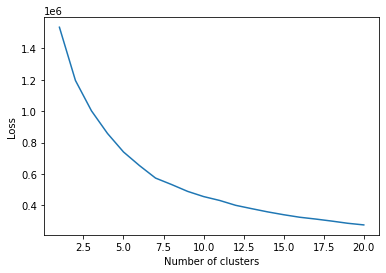

In [9]:
plt.plot(clusters_sin_cos, losses_sin_cos)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

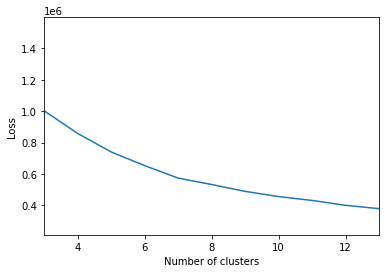

In [10]:
plt.plot(clusters_sin_cos, losses_sin_cos)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([3,13])
plt.show()

From the two plots above we expect seven clusters to be the best fit for our dataset.

In [11]:
# refit algorithm
means = KMeans(n_clusters=7, random_state=42,init="k-means++")
means.fit(X_scaled)

#todo: select cluster names
cluster_means = ["zero", "one", "two", "three","four","five","six"]

#add cluster lables to the dataset
X_scaled_df["cluster"] = means.predict(X_scaled)
X_scaled_df["cluster"] = X_scaled_df["cluster"].apply(lambda x: cluster_means[x])

#add unedited features for better visual representation
X_scaled_df["duration"]= df_sin_cos.trip_duration_in_hours
X_scaled_df["hour"]=df_sin_cos.hour
X_scaled_df["day_of_week"]=df_sin_cos.day_of_week
X_scaled_df["start_station_id"]=df.start_station_id

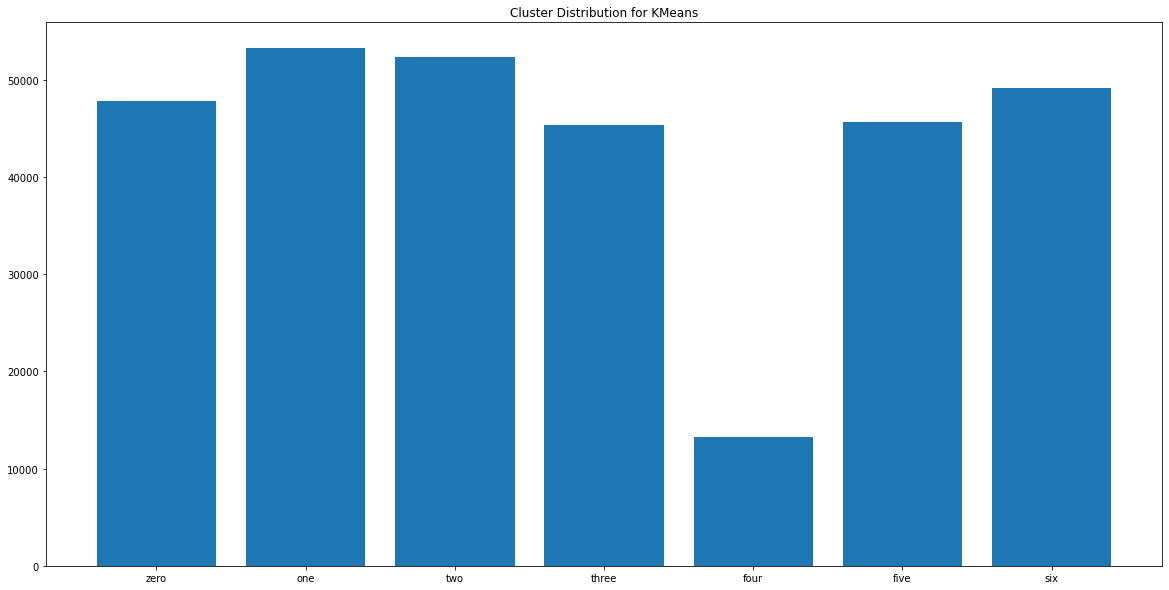

In [12]:
count = [len(X_scaled_df[X_scaled_df.cluster==cluster_means[i]]) for i in range(len(cluster_means))]
plt.figure(figsize=(20,10))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_means,count)
plt.show()

**todo: describe plots; user/trip types indentified**

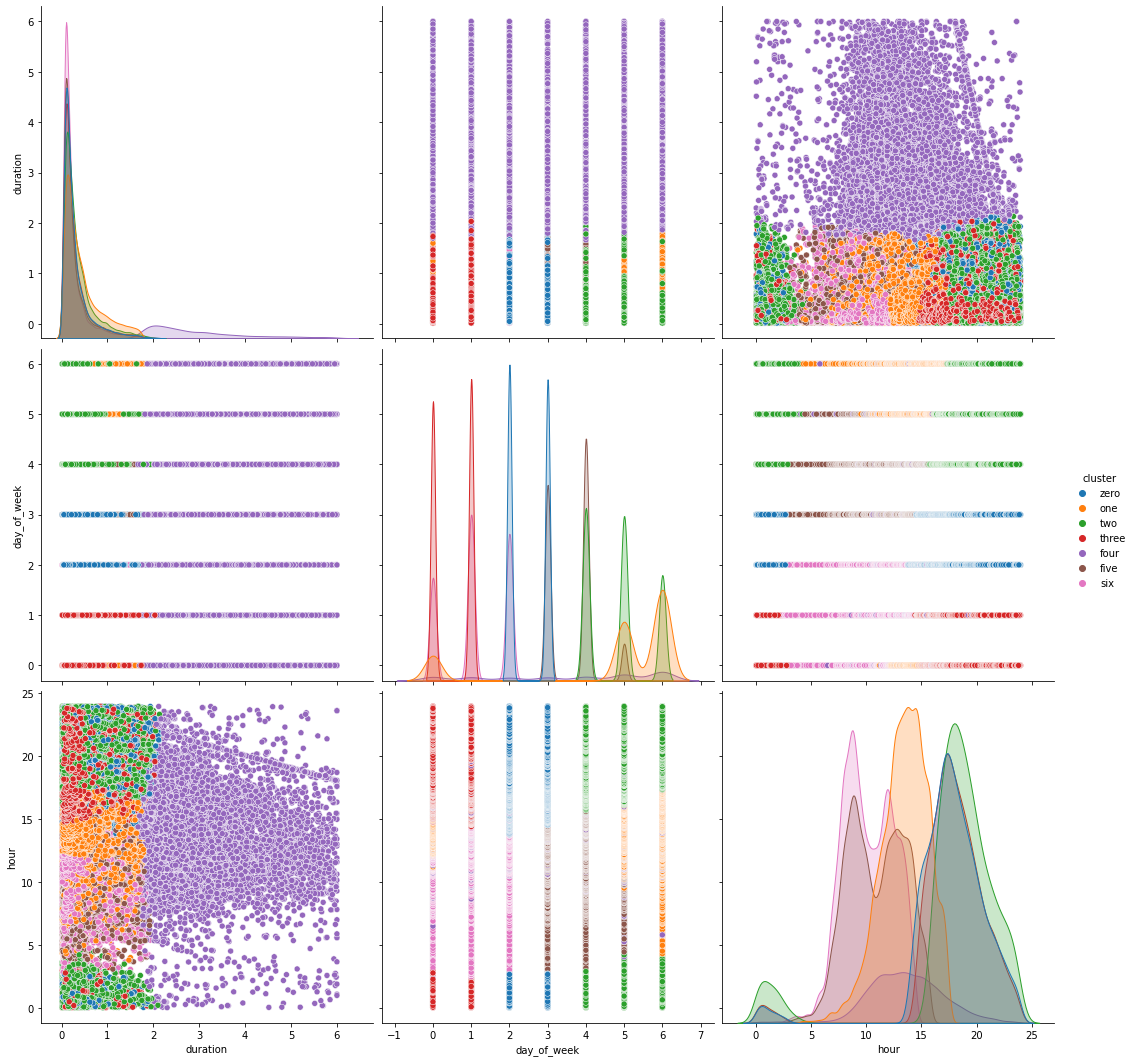

In [13]:
sns.pairplot(data=X_scaled_df, hue="cluster", hue_order=cluster_means, height=5, vars=["duration","day_of_week","hour"])

<AxesSubplot:xlabel='day_of_week', ylabel='Density'>

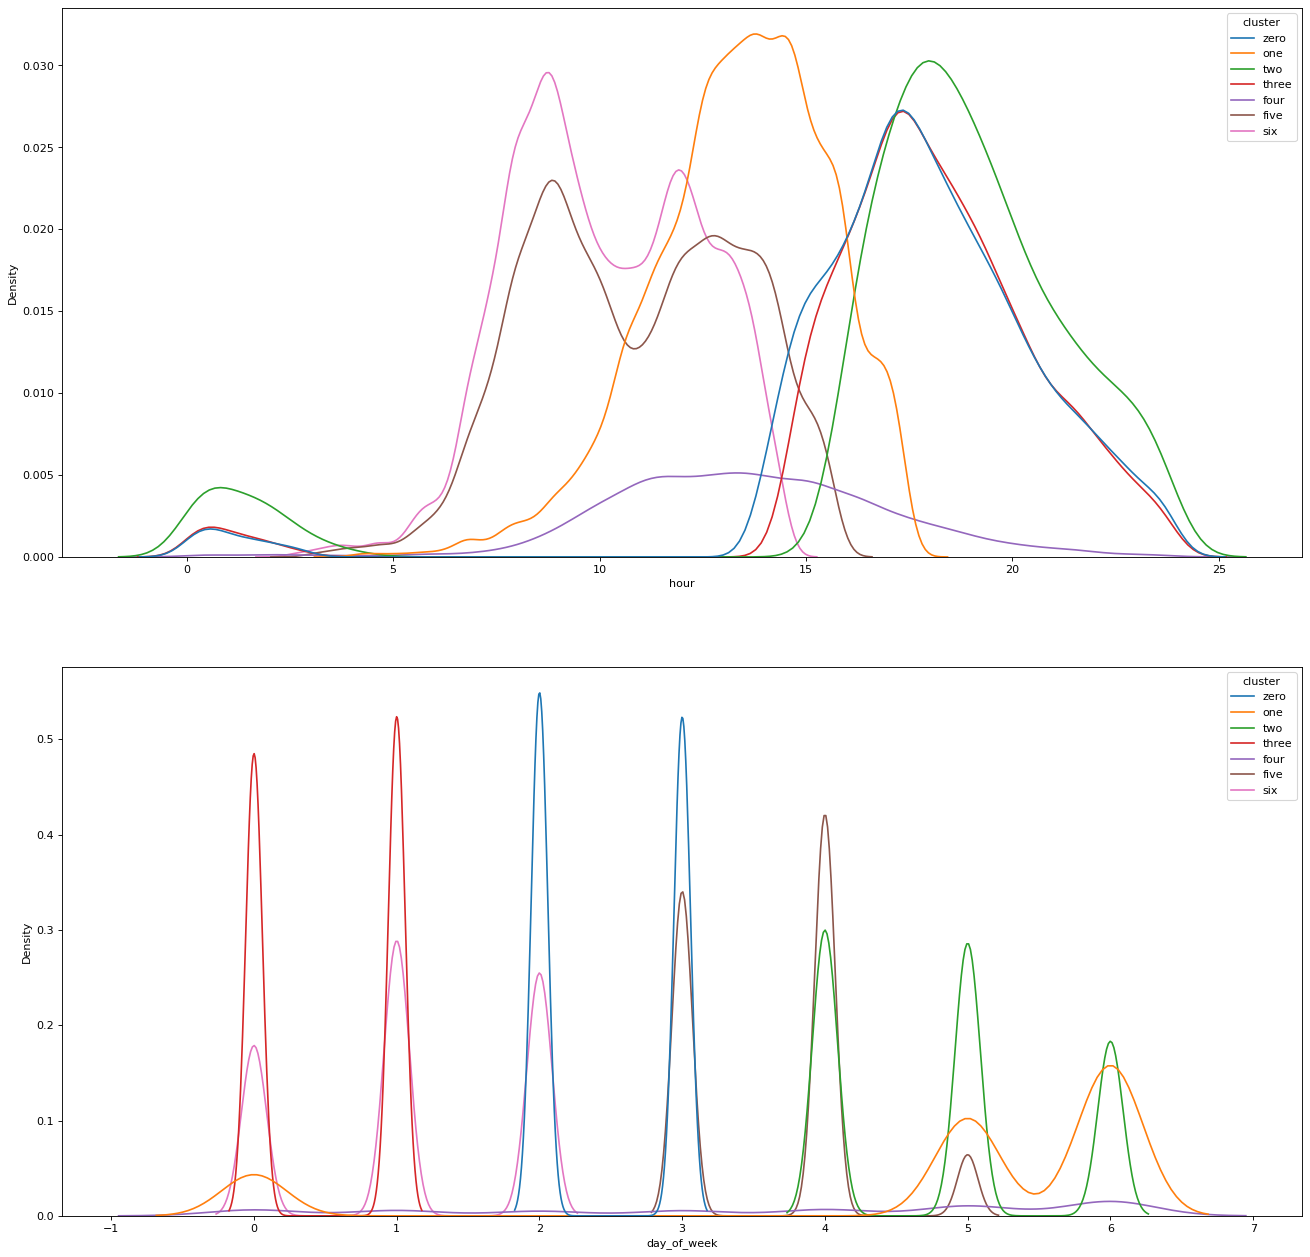

In [14]:
fig,ax = plt.subplots(2,1,figsize=(20,20), dpi= 80) 
axis_font = {'size':'20'}
label_font = {'labelsize':'12'}
dic={'fontsize': '24'}

sns.kdeplot(data=X_scaled_df, x="hour", hue="cluster",hue_order=cluster_means, ax=ax[0])
sns.kdeplot(data=X_scaled_df, x="day_of_week", hue="cluster",hue_order=cluster_means, ax=ax[1])

In [15]:
santa_monica_list = [4204, 4216, 4207, 4214, 4215, 4212, 4210, 4205, 4211, 4209, 4202, 4206, 4208, 4213]
la_center_list = [3063, 3018, 3006, 3051, 3022, 3082, 3048, 3030, 3074, 3049, 3031, 3027, 3035, 3078, 3007, 3077, 3026, 3005, 3081, 3076, 3029, 3067, 3023, 3055, 3052, 3042, 3065, 3064, 3025, 3046, 3054, 3068, 3047, 3056, 3038, 3032, 3037, 3034, 3016, 3024, 3019, 3014, 3069, 3033, 3040, 3066, 3011, 3062, 3008, 3058, 3057, 4220, 3075, 3080, 3079, 4227, 3013, 3036, 3028, 3010, 3020, 3045, 4254, 4249, 4246, 4250, 4245, 4267, 4273, 4276]
pasadena_list = [4147, 4165, 4155, 4149, 4162, 4176, 4174, 4153, 4152, 4181, 4144, 4154, 4169, 4142, 4163, 4146, 4167, 4170, 4151, 4150, 4177, 4180, 4157, 4158, 4148, 4156, 4160, 4159, 4138, 4166, 4183]
san_pedro_list = [4130, 4131, 4134, 4132, 4126, 4129, 4136, 3013, 4127, 4133, 4125, 4135]

In [16]:
santa_monica_df=X_scaled_df[X_scaled_df.start_station_id.isin(santa_monica_list)]
la_center_df=X_scaled_df[X_scaled_df.start_station_id.isin(la_center_list)]
pasadena_df=X_scaled_df[X_scaled_df.start_station_id.isin(pasadena_list)]
san_pedro_df=X_scaled_df[X_scaled_df.start_station_id.isin(san_pedro_list)]

**todo: describe plots;station types indentified**

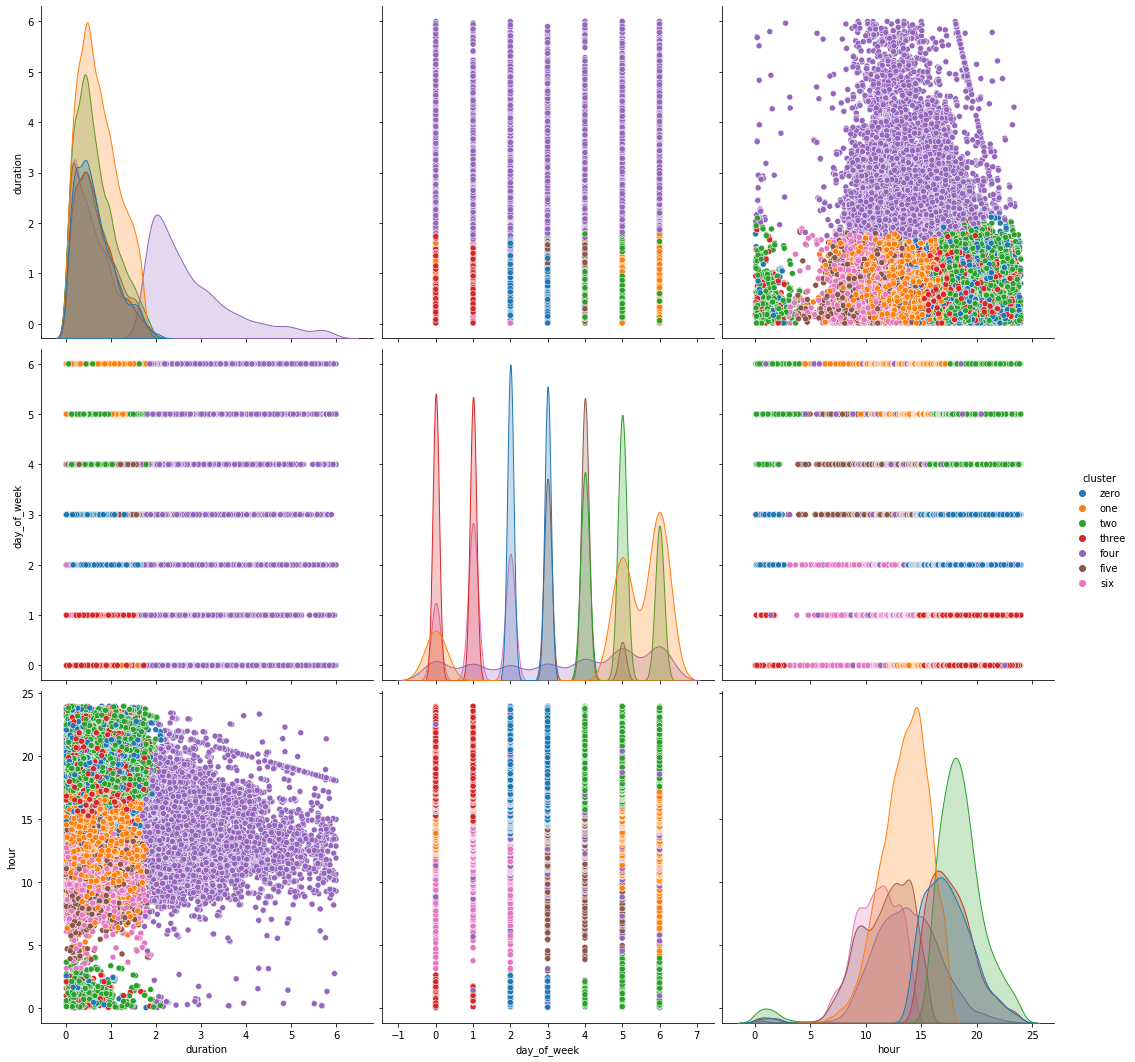

In [17]:
sns.pairplot(data=santa_monica_df, hue="cluster",hue_order=cluster_means,height=5, vars=["duration","day_of_week","hour"])

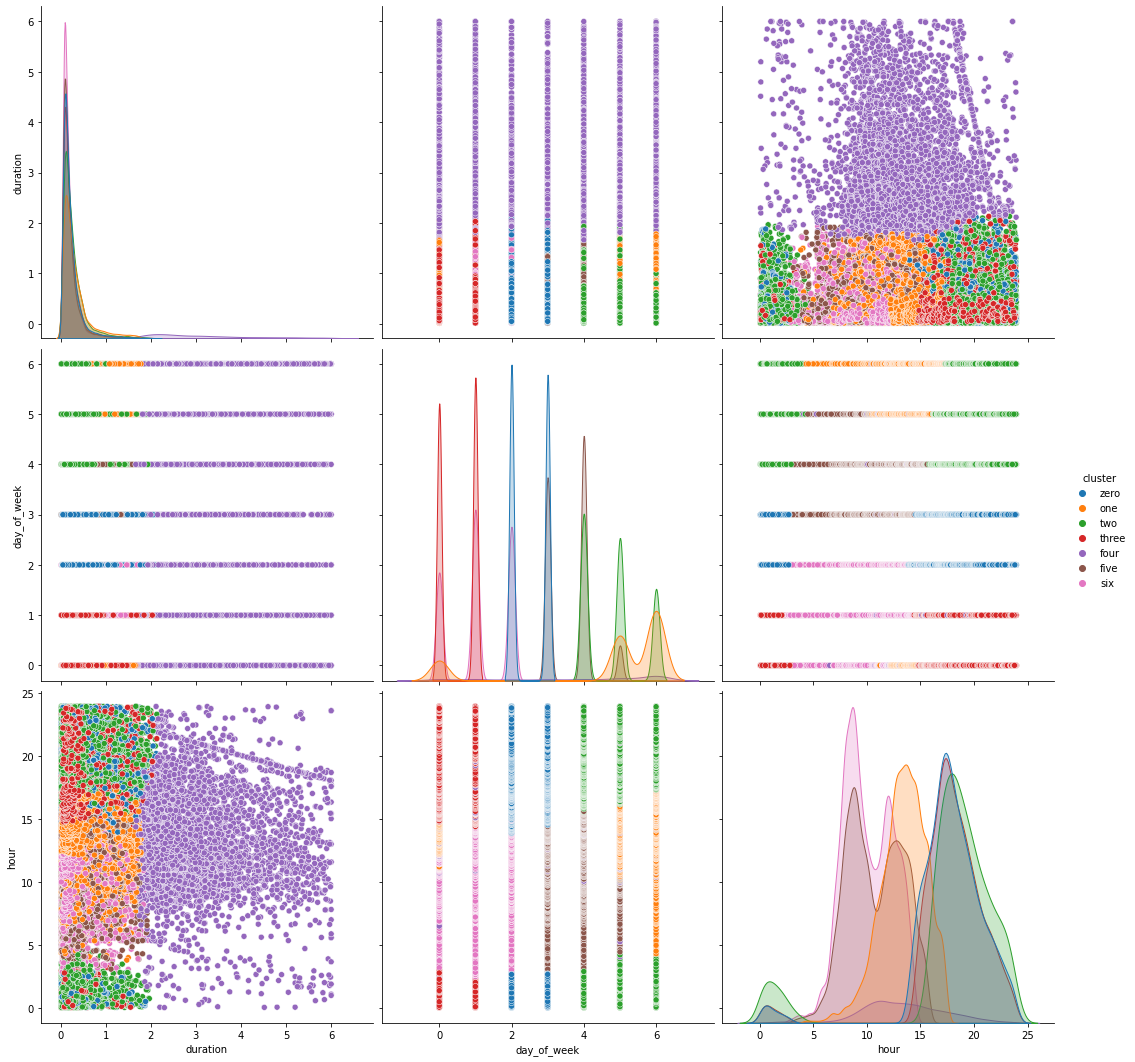

In [18]:
sns.pairplot(data=la_center_df, hue="cluster",hue_order=cluster_means,height=5, vars=["duration","day_of_week","hour"])

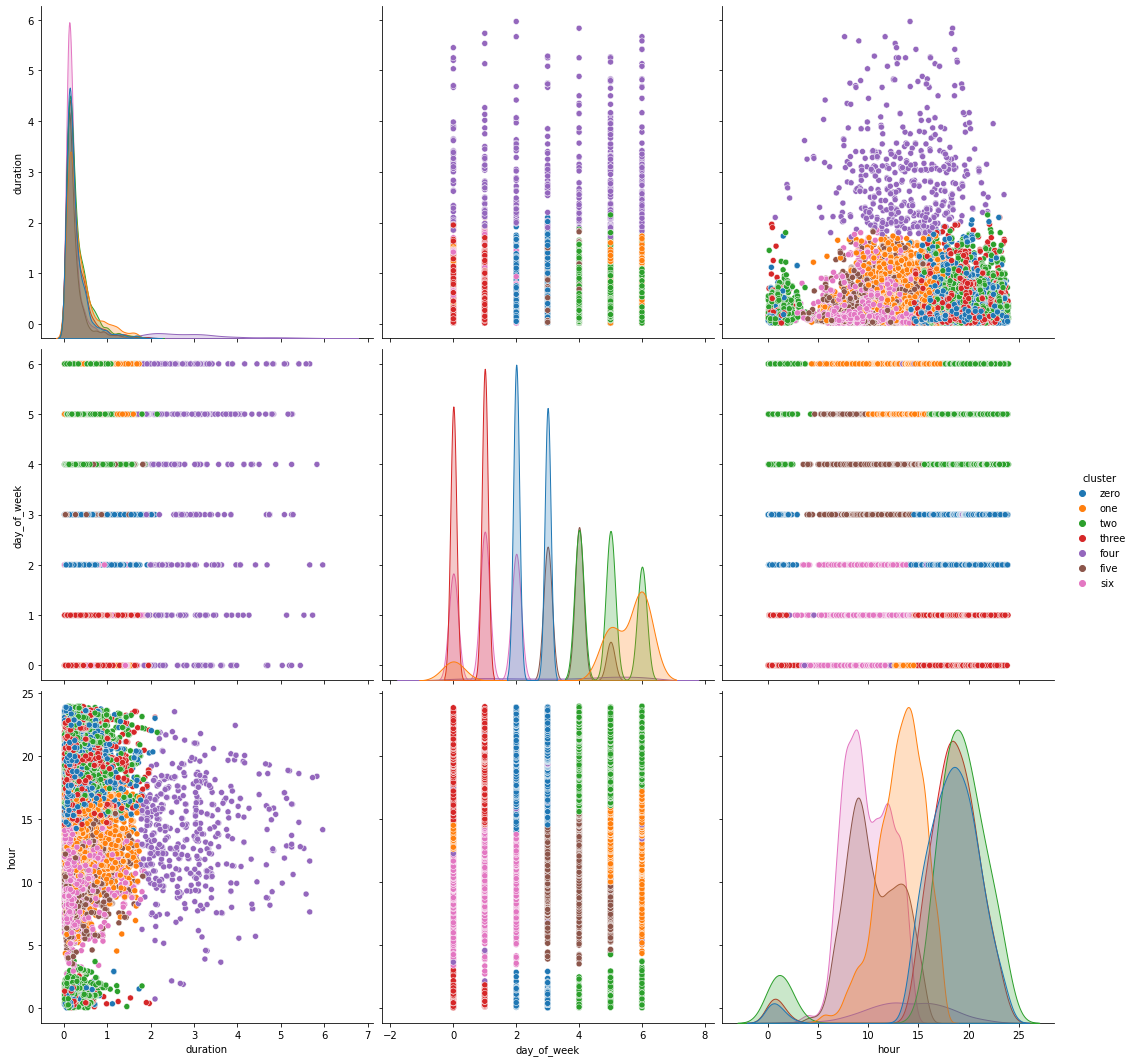

In [19]:
sns.pairplot(data=pasadena_df, hue="cluster",hue_order=cluster_means,height=5, vars=["duration","day_of_week","hour"])

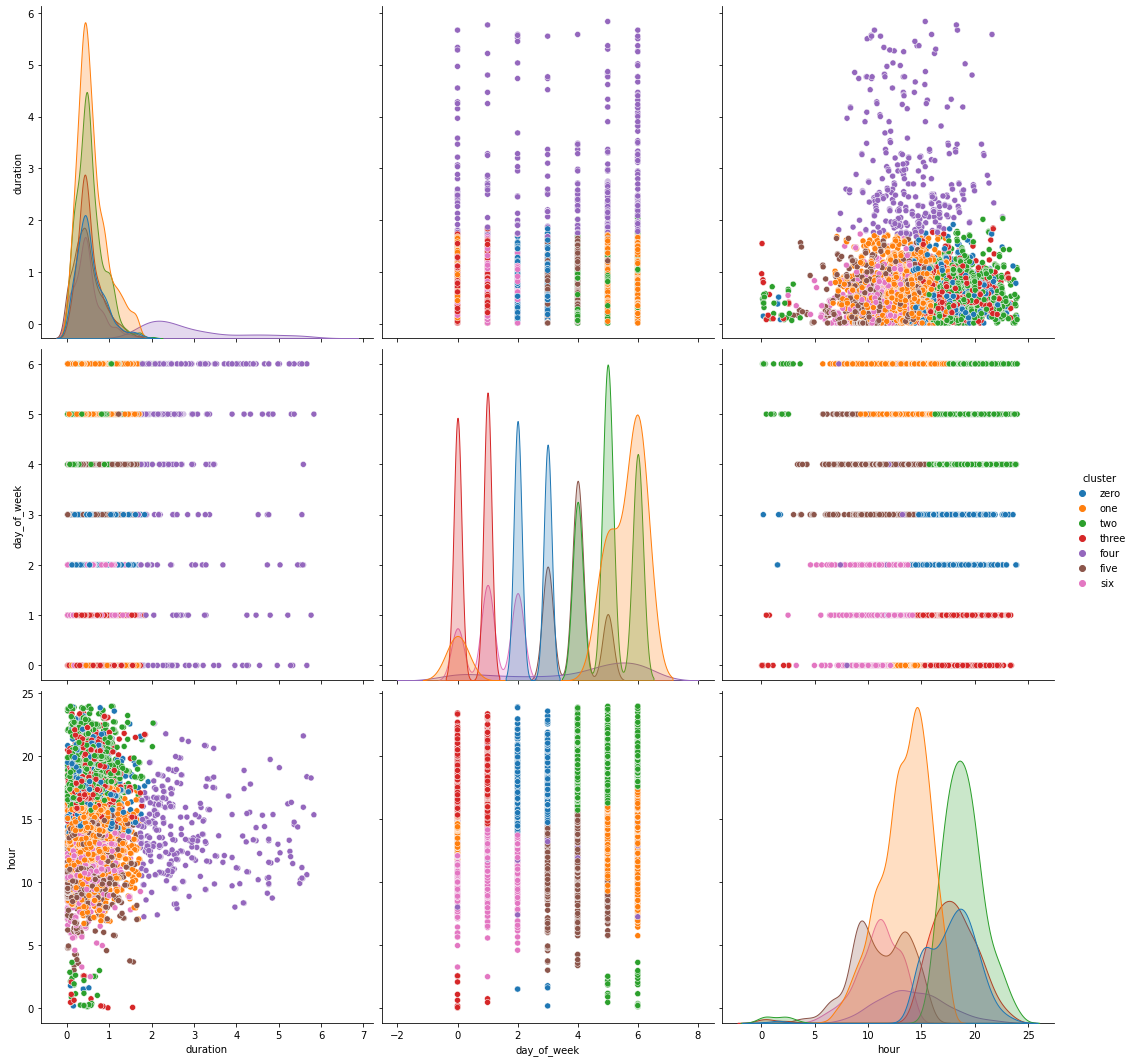

In [20]:
sns.pairplot(data=san_pedro_df, hue="cluster",hue_order=cluster_means,height=5, vars=["duration","day_of_week","hour"])

# Cluster stations

**todo:description**<br>
cluster stations after usage -> start or end of a rental

In [21]:
#create d df with time of usage and station id
df_start_staion = df[["start_time","start_station_id"]].copy()
df_start_staion.rename(columns={"start_time":"time","start_station_id":"station_id"}, inplace=True)
df_end_staion = df[["end_time","end_station_id"]].copy()
df_end_staion.rename(columns={"end_time":"time","end_station_id":"station_id"}, inplace=True)
df_station = df_start_staion.append(df_end_staion, ignore_index=True)

# add usage count
df_station["usage"]=1

df_station.set_index("time",inplace=True)
df_station

station_id  usage
time                                  
2018-01-01 00:04:00        3063      1
2018-01-01 00:05:00        3063      1
2018-01-01 00:06:00        3063      1
2018-01-01 00:13:00        3018      1
2018-01-01 00:14:00        4204      1
...                         ...    ...
2018-12-31 23:54:00        3030      1
2018-12-31 23:56:00        3046      1
2018-12-31 23:56:00        3046      1
2018-12-31 23:55:00        3069      1
2018-12-31 23:54:00        3069      1

[613726 rows x 2 columns]

In [22]:
# create time series data of usage for all staions
grouper=df_station.groupby([pd.Grouper(freq='1H'), 'station_id'],)
station_cluster=grouper.count().unstack('station_id').fillna(0)

station_cluster=station_cluster.transpose()
station_cluster=station_cluster.droplevel(0)
station_cluster

time        2018-01-01 00:00:00  2018-01-01 01:00:00  2018-01-01 02:00:00  \
station_id                                                                  
3000                        0.0                  0.0                  0.0   
3005                        0.0                  0.0                  3.0   
3006                        2.0                  0.0                  0.0   
3007                        0.0                  1.0                  0.0   
3008                        0.0                  0.0                  0.0   
...                         ...                  ...                  ...   
4266                        0.0                  0.0                  0.0   
4267                        0.0                  0.0                  0.0   
4273                        0.0                  0.0                  0.0   
4275                        0.0                  0.0                  0.0   
4276                        0.0                  0.0                  0.0   

time        2018-01-01 03:00:00  2018-01-01 04:00:00  2018-01-01 05:00:00  \
station_id                                                                  
3000                        0.0                  0.0                  0.0   
3005                        0.0                  0.0                  1.0   
3006                        0.0                  0.0                  0.0   
3007                        0.0                  0.0                  0.0   
3008                        0.0                  0.0                  0.0   
...                         ...                  ...                  ...   
4266                        0.0                  0.0                  0.0   
4267                        0.0                  0.0                  0.0   
4273                        0.0                  0.0                  0.0   
4275                        0.0                  0.0                  0.0   
4276                        0.0                  0.0                  0.0   

time        2018-01-01 06:00:00  2018-01-01 07:00:00  2018-01-01 08:00:00  \
station_id                                                                  
3000                        0.0                  0.0                  0.0   
3005                        0.0                  0.0                  0.0   
3006                        0.0                  0.0                  0.0   
3007                        0.0                  0.0                  0.0   
3008                        0.0                  2.0                  0.0   
...                         ...                  ...                  ...   
4266                        0.0                  0.0                  0.0   
4267                        0.0                  0.0                  0.0   
4273                        0.0                  0.0                  0.0   
4275                        0.0                  0.0                  0.0   
4276                        0.0                  0.0                  0.0   

time        2018-01-01 09:00:00  ...  2018-12-31 14:00:00  \
station_id                       ...                        
3000                        0.0  ...                  0.0   
3005                        0.0  ...                  3.0   
3006                        0.0  ...                  5.0   
3007                        0.0  ...                  3.0   
3008                        0.0  ...                  1.0   
...                         ...  ...                  ...   
4266                        0.0  ...                  0.0   
4267                        0.0  ...                  0.0   
4273                        0.0  ...                  0.0   
4275                        0.0  ...                  0.0   
4276                        0.0  ...                  0.0   

time        2018-12-31 15:00:00  2018-12-31 16:00:00  2018-12-31 17:00:00  \
station_id                                                                  
3000                        3.0               

To use TimeSeriesKMeans we have to transform the dataset to a numpy-array of shape = (number of time series, size of time series, dimension of time series).

In [23]:
station_cluster_array = station_cluster.to_numpy().reshape(132,8529,1)
station_cluster_array

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [3.],
        ...,
        [0.],
        [2.],
        [0.]],

       [[2.],
        [0.],
        [0.],
        ...,
        [3.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

**todo: explain selected parameters, timeseried kmeans**

In [24]:
k_max =100
clusters = []
losses = []

for k in range(k_max):
    model = TimeSeriesKMeans(n_clusters=k+1,random_state=42).fit(station_cluster_array)
    clusters.append(k+1)
    losses.append(model.inertia_)

We use the elbow method to determine the best number of clusters for the station demand data.

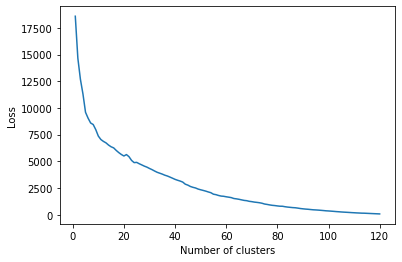

In [25]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

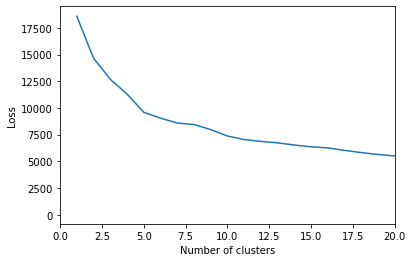

In [26]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([0,20])
plt.show()

From the two plots above we expect five clusters to be the best fit for our dataset.

In [27]:
#todo: who to get data for stations ?
df_geo=pd.read_csv('../data/LA_geo.csv')

df_start_staion1 = df_geo[["start_lon","start_lat","start_station_id"]].copy()
df_start_staion1.rename(columns={"start_lon":"lon","start_lat":"lat","start_station_id":"station_id"}, inplace=True)
df_end_staion1 = df_geo[["end_lon","end_lat","end_station_id"]].copy()
df_end_staion1.rename(columns={"end_lon":"lon","end_lat":"lat","end_station_id":"station_id"}, inplace=True)
df_station1 = df_start_staion1.append(df_end_staion1, ignore_index=True)
df_station1=df_station1.groupby("station_id").mean()
df_station1

lon        lat
station_id                       
3000               NaN        NaN
3005       -118.258537  34.048500
3006       -118.256668  34.045540
3007       -118.254593  34.050480
3008       -118.262733  34.046612
...                ...        ...
4266               NaN        NaN
4267       -118.280678  34.027618
4273       -118.284103  34.025860
4275       -118.285896  34.012520
4276       -118.218849  34.047390

[132 rows x 2 columns]

In [28]:
#refit model
means_ts = TimeSeriesKMeans(n_clusters=5, max_iter=50,random_state=42).fit(station_cluster_array)
means_ts.fit(station_cluster_array)

#todo: selct lable names
numbers = ["zero", "one", "two", "three","four"]

# add culculated clusters ta dataset
df_station1["cluster"] = means_ts.predict(station_cluster_array)
df_station1["cluster"] = df_station1["cluster"].apply(lambda x: numbers[x])
df_station2=df_station1.dropna()#todo: full dataset?
df_station2

lon        lat cluster
station_id                               
3005       -118.258537  34.048500     two
3006       -118.256668  34.045540   three
3007       -118.254593  34.050480   three
3008       -118.262733  34.046612   three
3010       -118.254868  34.037048    zero
...                ...        ...     ...
4254       -118.284111  34.028679    zero
4267       -118.280678  34.027618    zero
4273       -118.284103  34.025860    zero
4275       -118.285896  34.012520    zero
4276       -118.218849  34.047390    zero

[128 rows x 3 columns]

In [29]:
#seperate clusters in own dfs
cluster_0 = df_station1[df_station1.cluster==numbers[0]].index
cluster_1 = df_station1[df_station1.cluster==numbers[1]].index
cluster_2 = df_station1[df_station1.cluster==numbers[2]].index
cluster_3 = df_station1[df_station1.cluster==numbers[3]].index
cluster_4 = df_station1[df_station1.cluster==numbers[4]].index

clusters=[cluster_0,cluster_1,cluster_2,cluster_3,cluster_4]

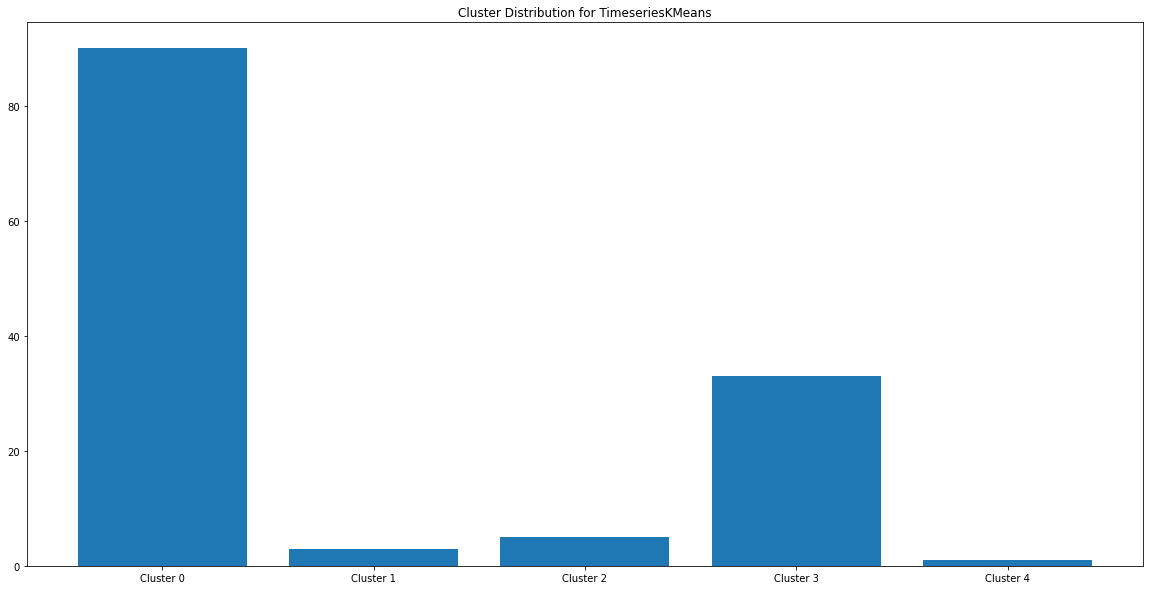

In [30]:
count = [len(clusters[i]) for i in range(len(clusters))]
cluster = ["Cluster "+str(i) for i in range(len(clusters))]
plt.figure(figsize=(20,10))
plt.title("Cluster Distribution for TimeseriesKMeans")
plt.bar(cluster,count)
plt.show()

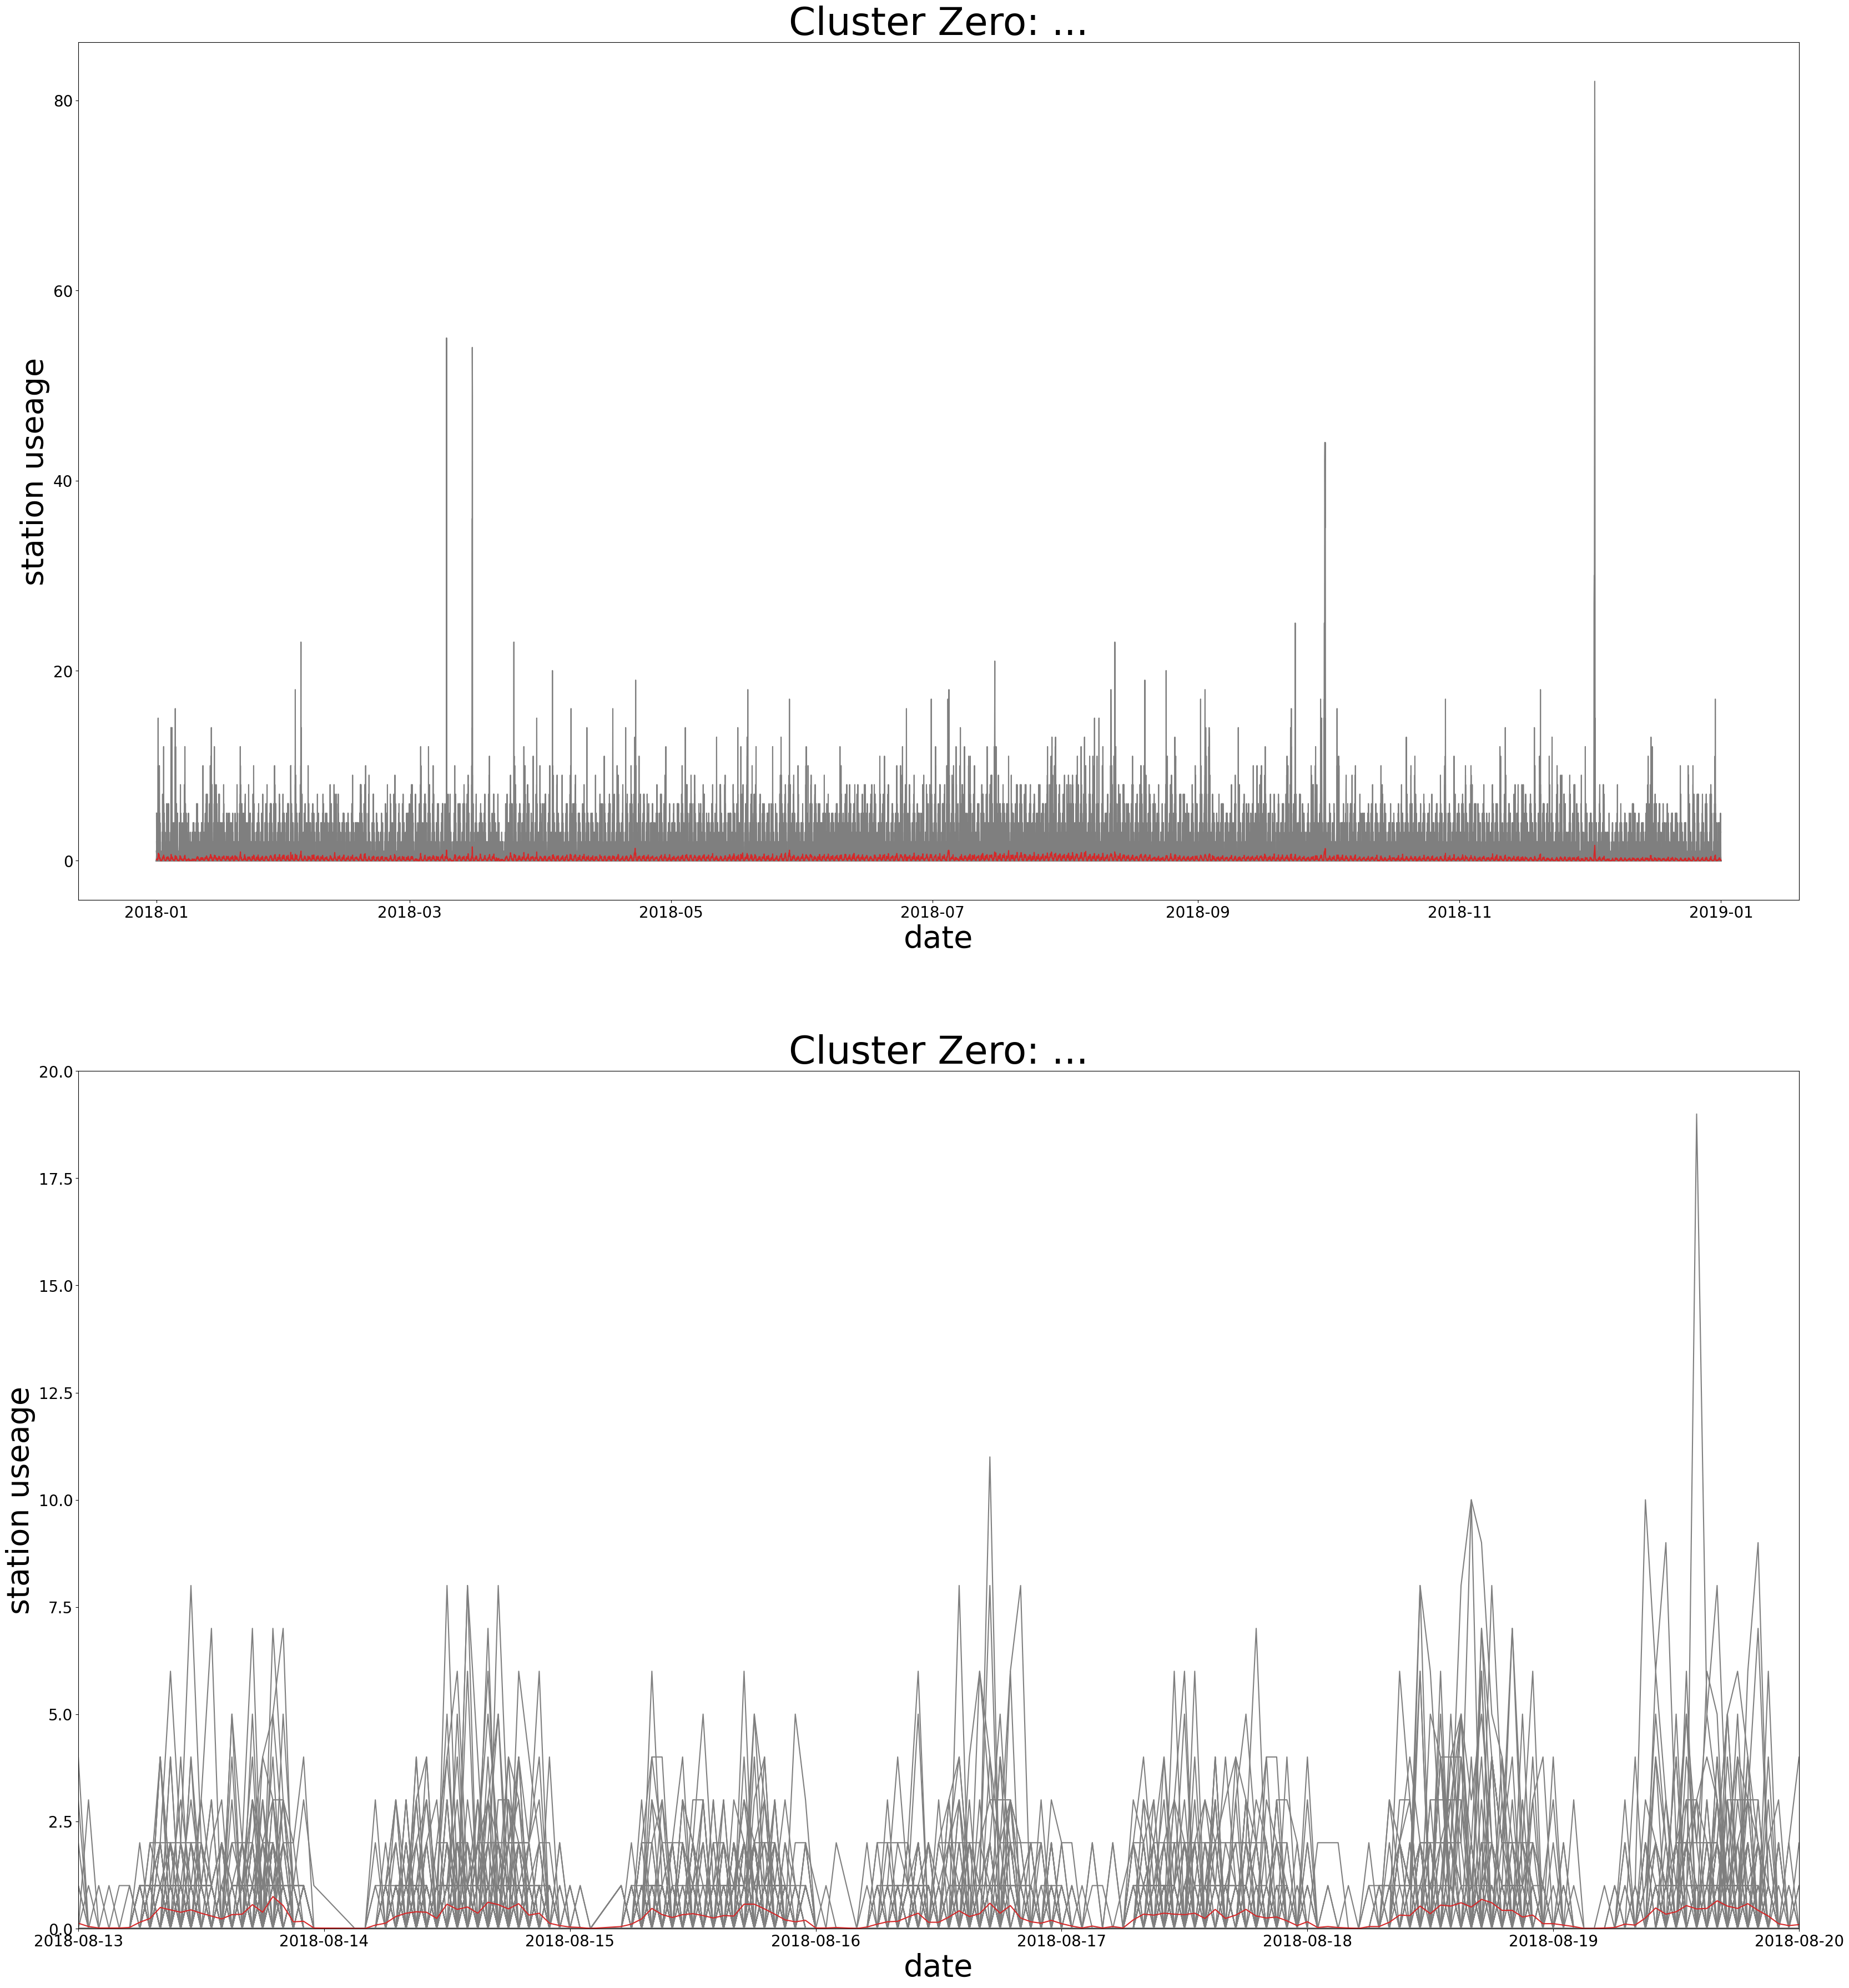

In [31]:
fig,ax = plt.subplots(2,1,figsize=(40,45), dpi=100) 
axis_font = {'size':'40'}
label_font = {'labelsize':'20'}
dic={'fontsize': '50'}

for i in [0,1]:
    for ts in cluster_0:
        #plot all timeseries of the respective cluster in gray
        ax[i].plot(station_cluster.transpose()[ts], color = 'tab:gray')
    
    #plot the mean value for all timeseries of the respective cluster in red
    ax[i].plot(station_cluster[station_cluster.index.isin(cluster_0)].mean(), color = 'tab:red')

    ax[i].set_title("Cluster Zero: ...", dic)
    ax[i].set_ylabel('station useage',**axis_font)
    ax[i].set_xlabel('date',**axis_font)
    ax[i].tick_params(axis='both', **label_font)

ax[1].set_xlim([datetime.date(2018, 8, 13), datetime.date(2018, 8, 20)])
ax[1].set_ylim([0,20])
    
plt.show()

**todo: describe cluster**

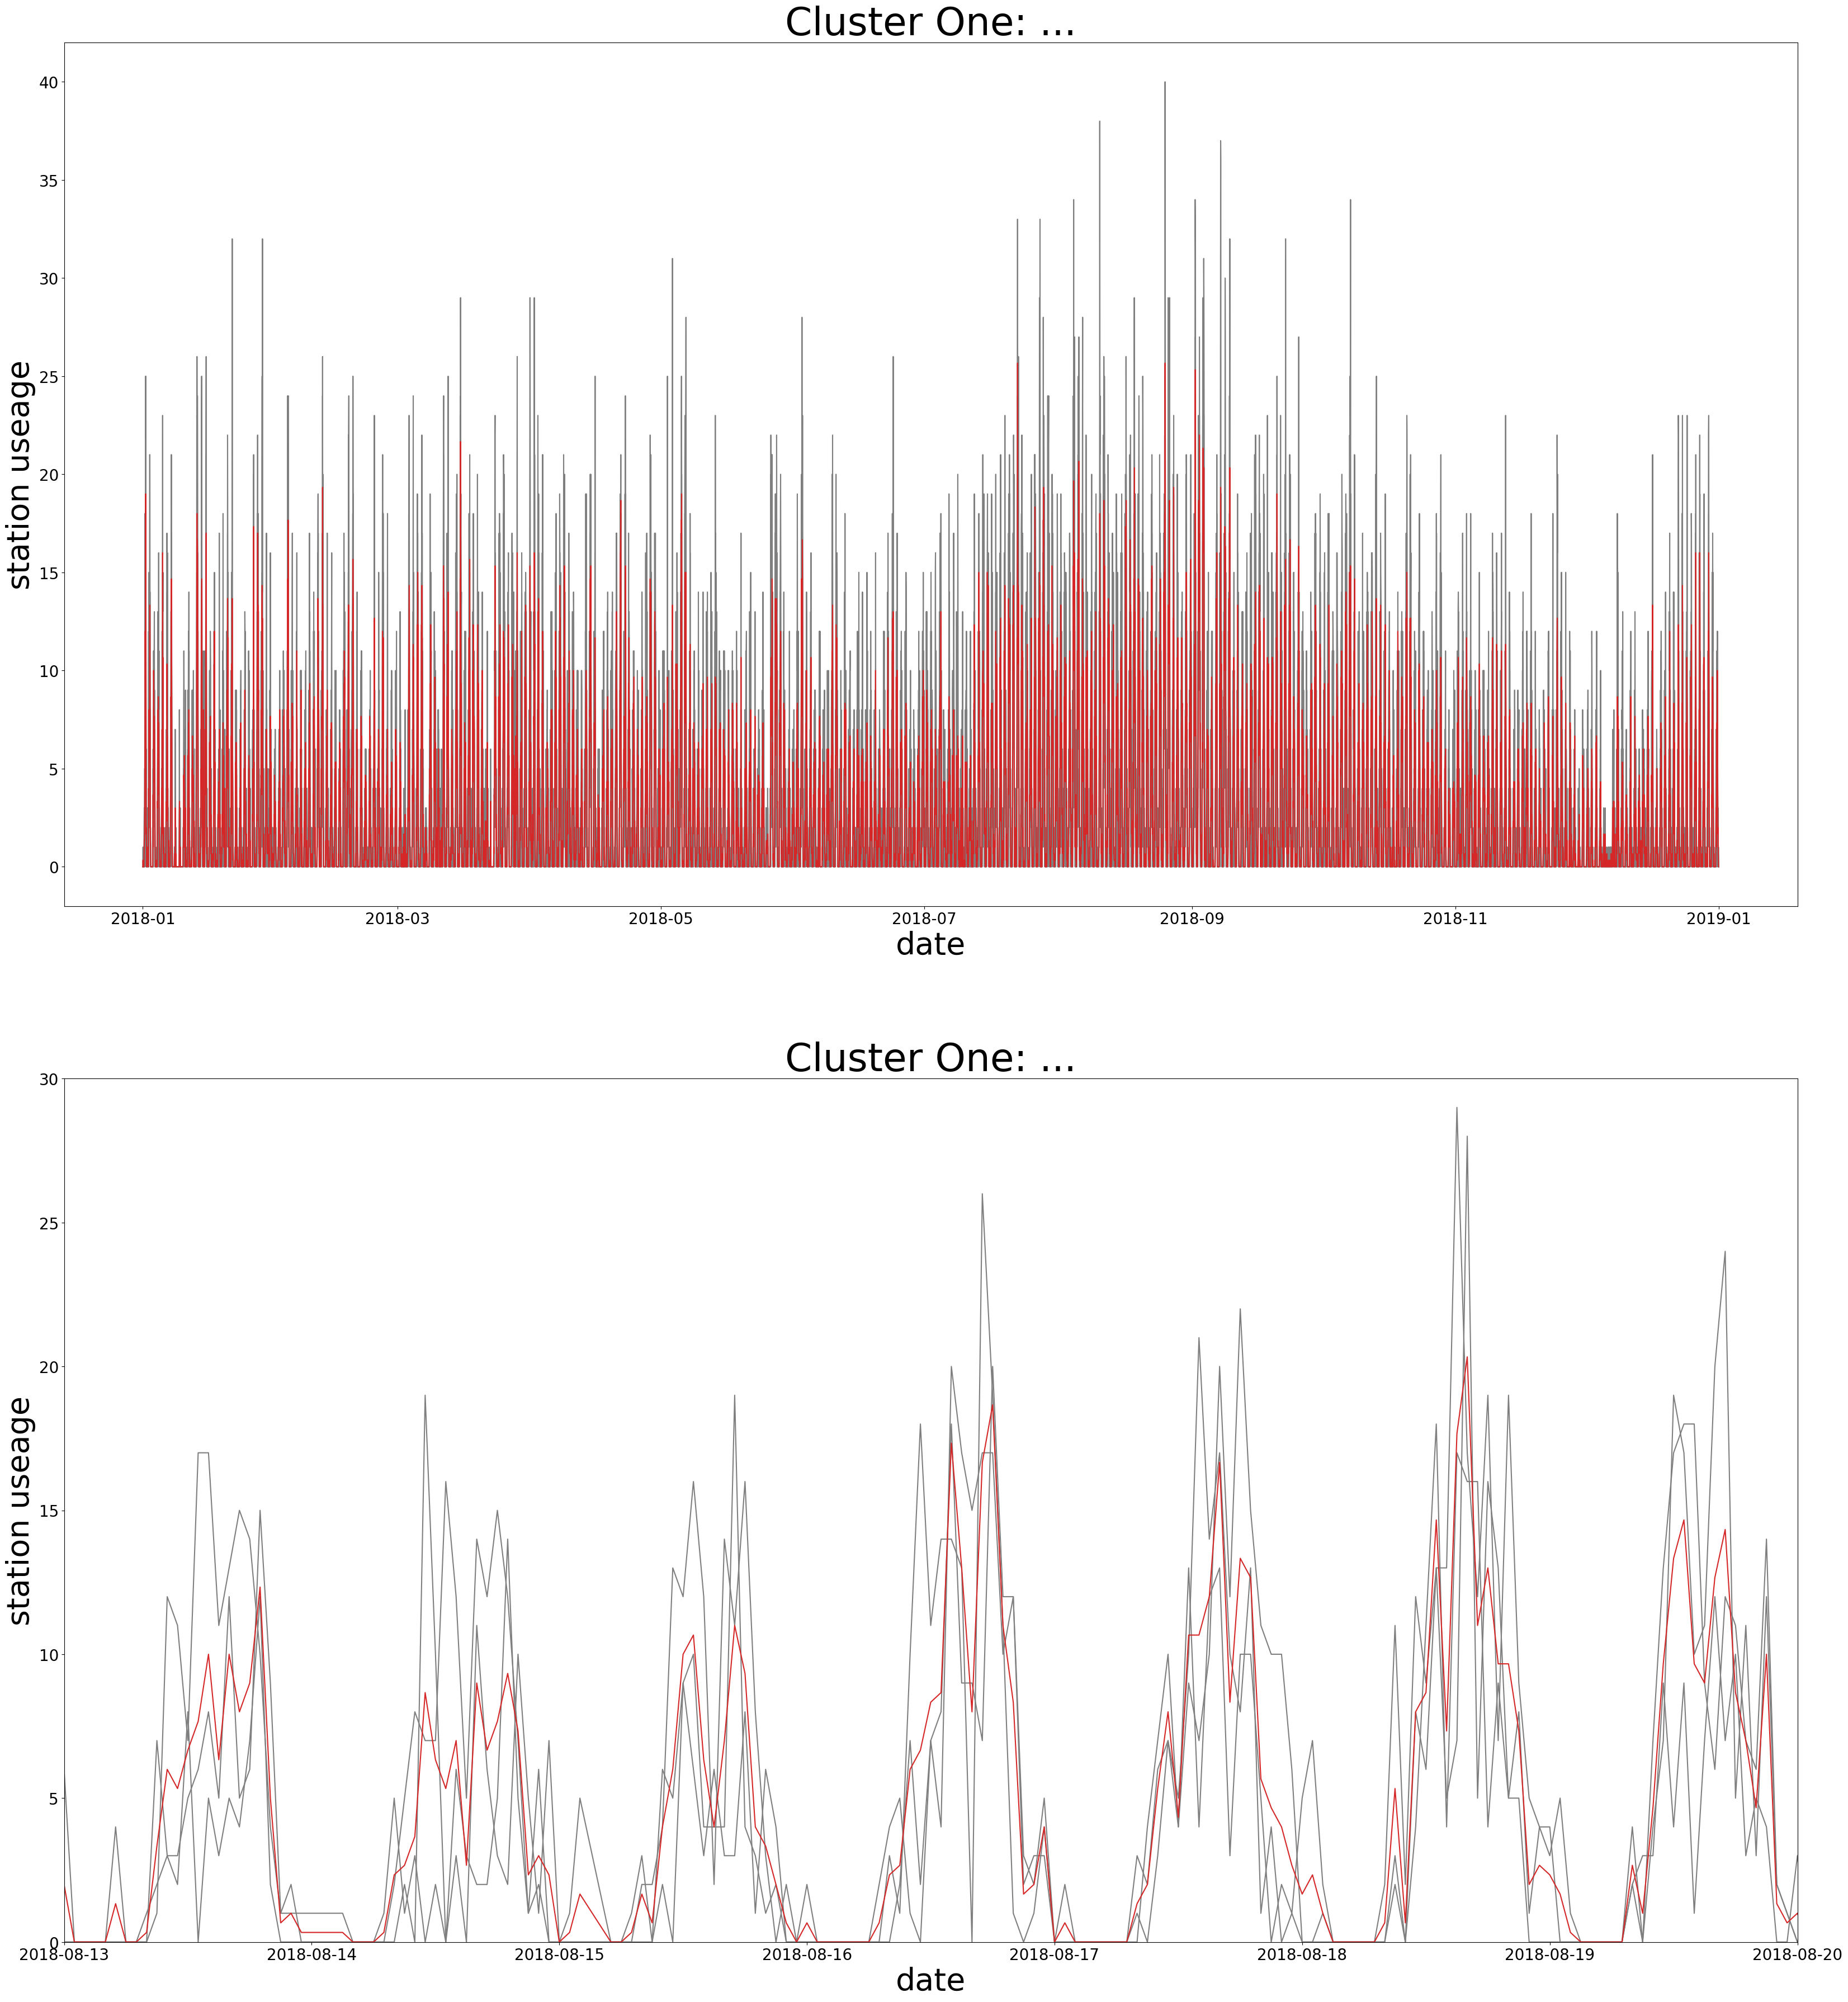

In [32]:
fig,ax = plt.subplots(2,1,figsize=(40,45), dpi= 100) 
axis_font = {'size':'40'}
label_font = {'labelsize':'20'}
dic={'fontsize': '50'}

for i in [0,1]:
    for ts in cluster_1:
        #plot all timeseries of the respective cluster in gray
        ax[i].plot(station_cluster.transpose()[ts], color = 'tab:gray')
    
    #plot the mean value for all timeseries of the respective cluster in red
    ax[i].plot(station_cluster[station_cluster.index.isin(cluster_1)].mean(), color = 'tab:red')

    ax[i].set_title("Cluster One: ...", dic)
    ax[i].set_ylabel('station useage',**axis_font)
    ax[i].set_xlabel('date',**axis_font)
    ax[i].tick_params(axis='both', **label_font)

ax[1].set_xlim([datetime.date(2018, 8, 13), datetime.date(2018, 8, 20)])
ax[1].set_ylim([0,30])
    
plt.show()

**todo: describe cluster**

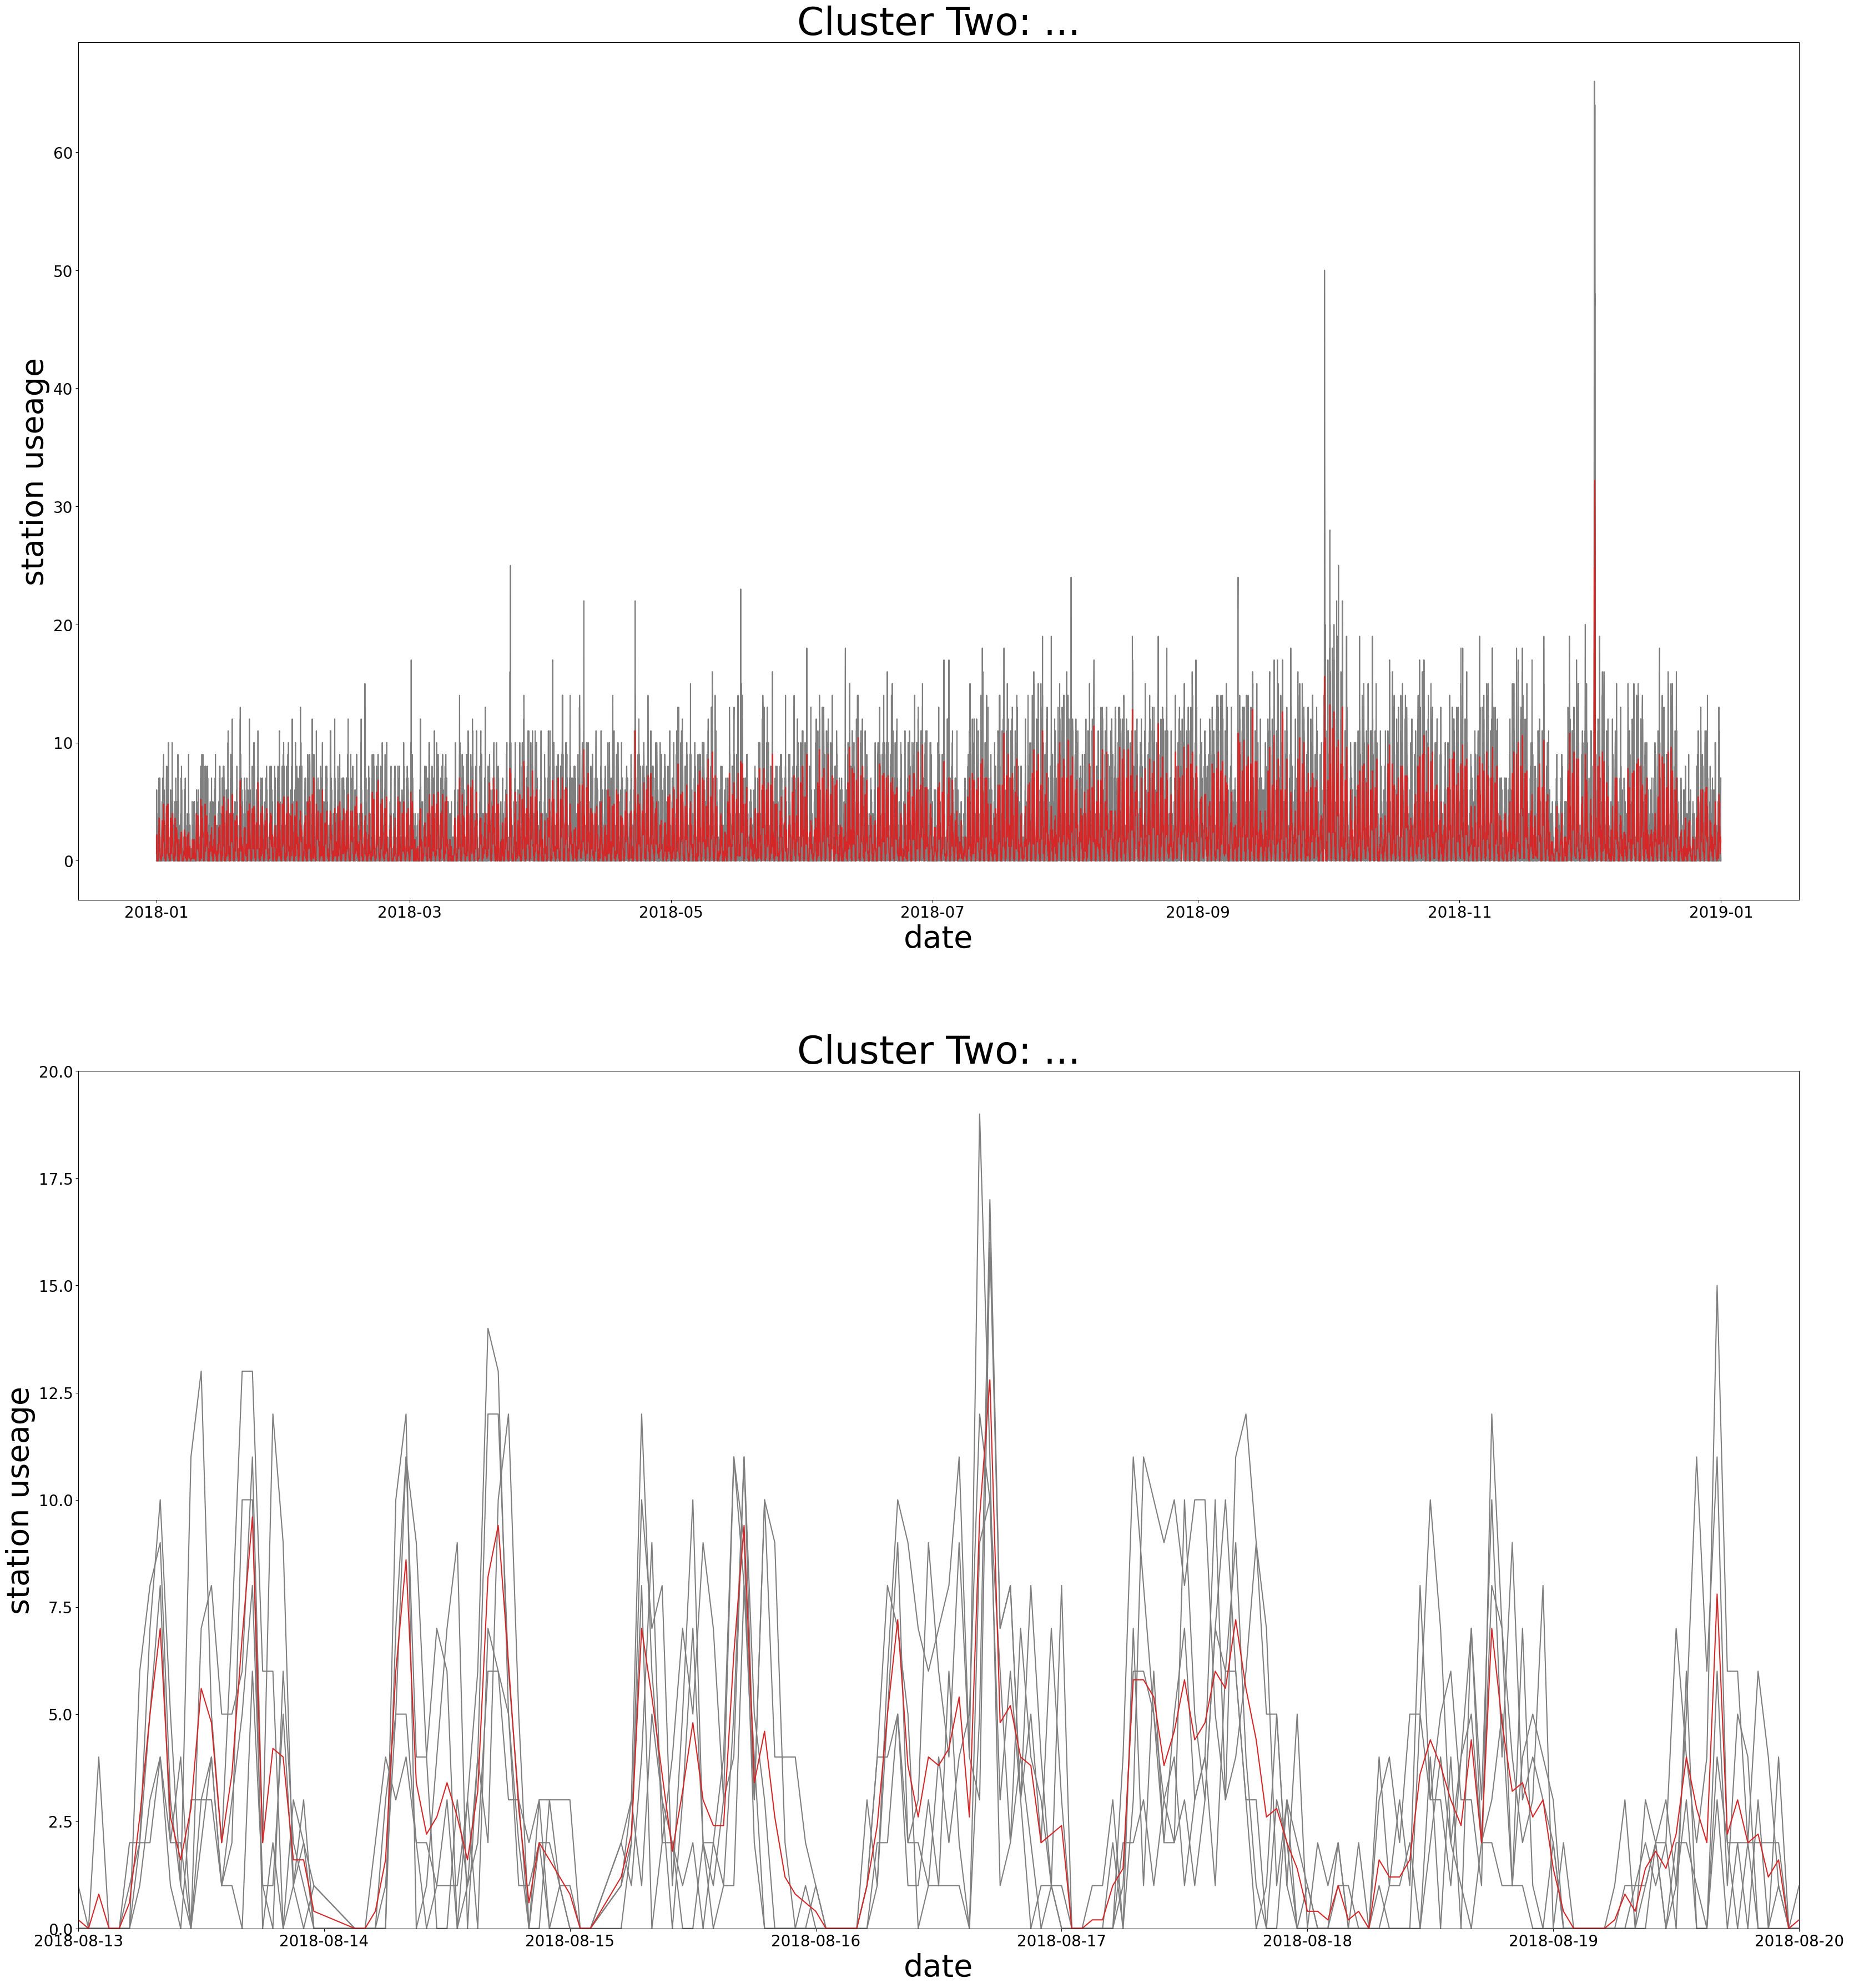

In [33]:
fig,ax = plt.subplots(2,1,figsize=(40,45), dpi=100) 
axis_font = {'size':'40'}
label_font = {'labelsize':'20'}
dic={'fontsize': '50'}

for i in [0,1]:
    for ts in cluster_2:
        #plot all timeseries of the respective cluster in gray
        ax[i].plot(station_cluster.transpose()[ts], color = 'tab:gray')
    
    #plot the mean value for all timeseries of the respective cluster in red
    ax[i].plot(station_cluster[station_cluster.index.isin(cluster_2)].mean(), color = 'tab:red')

    ax[i].set_title("Cluster Two: ...", dic)
    ax[i].set_ylabel('station useage',**axis_font)
    ax[i].set_xlabel('date',**axis_font)
    ax[i].tick_params(axis='both', **label_font)

ax[1].set_xlim([datetime.date(2018, 8, 13), datetime.date(2018, 8, 20)])
ax[1].set_ylim([0,20])
    
plt.show()

**todo: describe cluster**

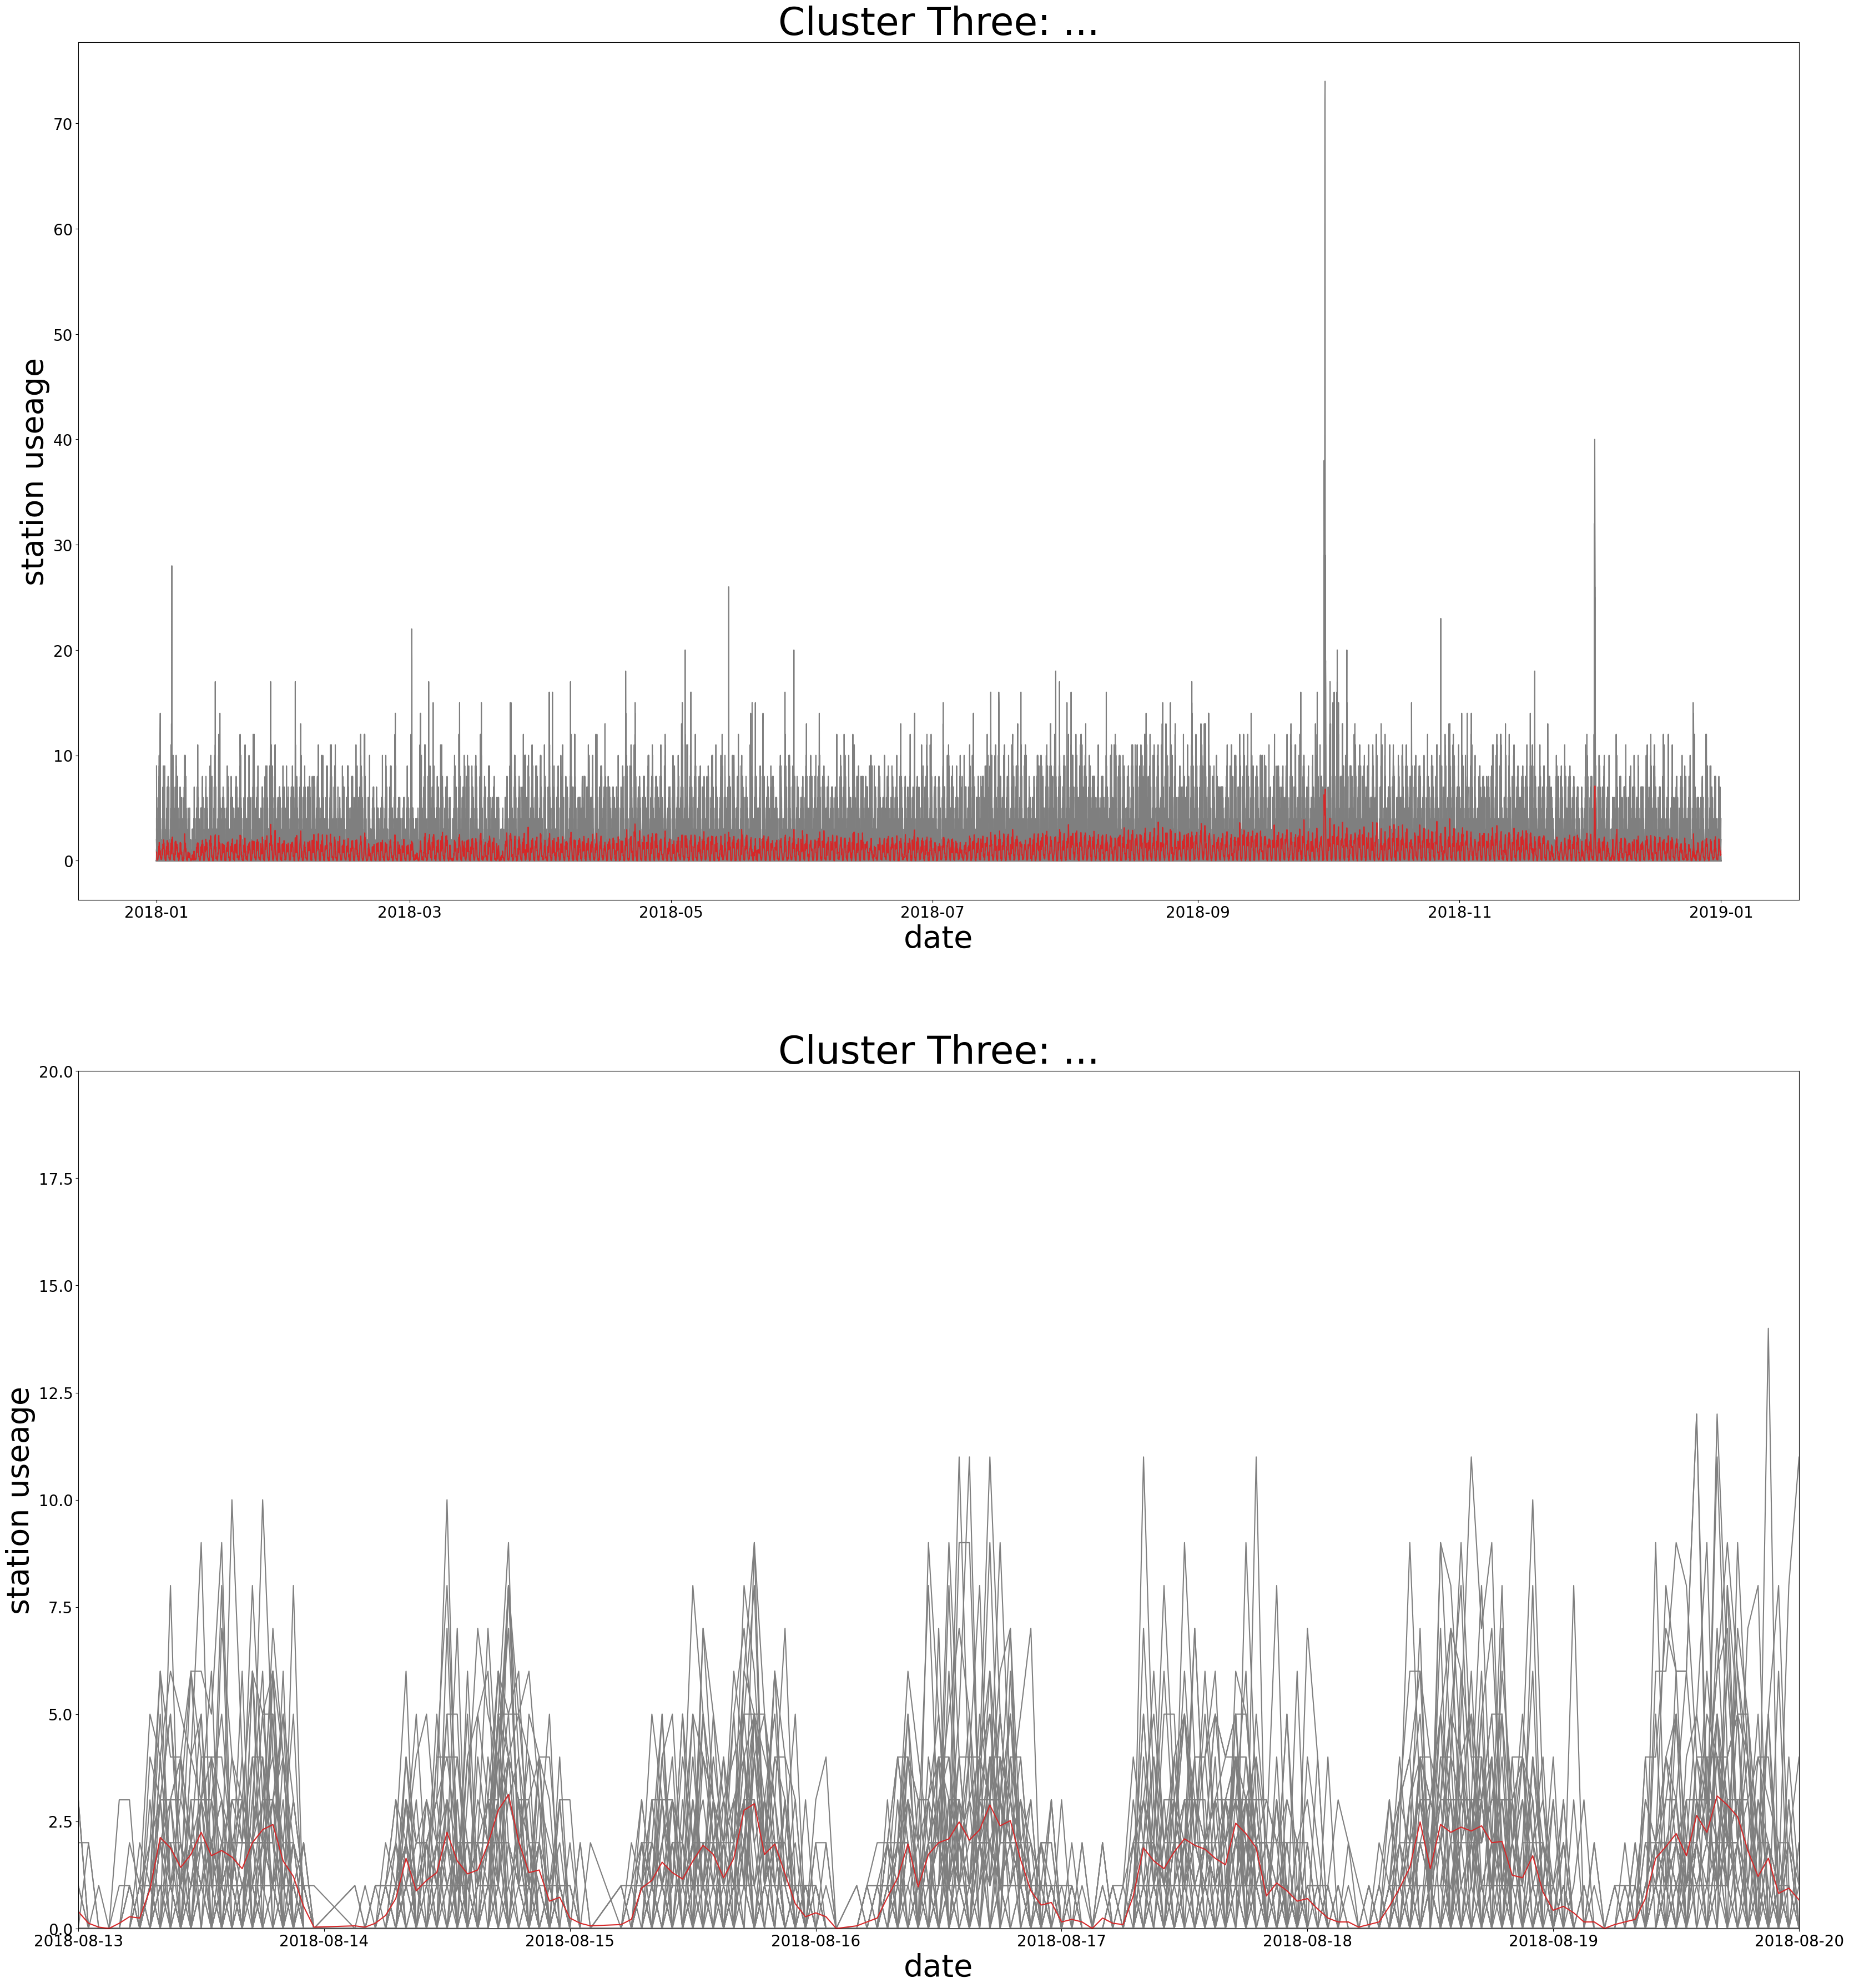

In [34]:
fig,ax = plt.subplots(2,1,figsize=(40,45), dpi=100) 
axis_font = {'size':'40'}
label_font = {'labelsize':'20'}
dic={'fontsize': '50'}

for i in [0,1]:
    for ts in cluster_3:
        #plot all timeseries of the respective cluster in gray
        ax[i].plot(station_cluster.transpose()[ts], color = 'tab:gray')
    
    #plot the mean value for all timeseries of the respective cluster in red
    ax[i].plot(station_cluster[station_cluster.index.isin(cluster_3)].mean(), color = 'tab:red')

    ax[i].set_title("Cluster Three: ...", dic)
    ax[i].set_ylabel('station useage',**axis_font)
    ax[i].set_xlabel('date',**axis_font)
    ax[i].tick_params(axis='both', **label_font)

ax[1].set_xlim([datetime.date(2018, 8, 13), datetime.date(2018, 8, 20)])
ax[1].set_ylim([0,20])
    
plt.show()

**todo: describe cluster**

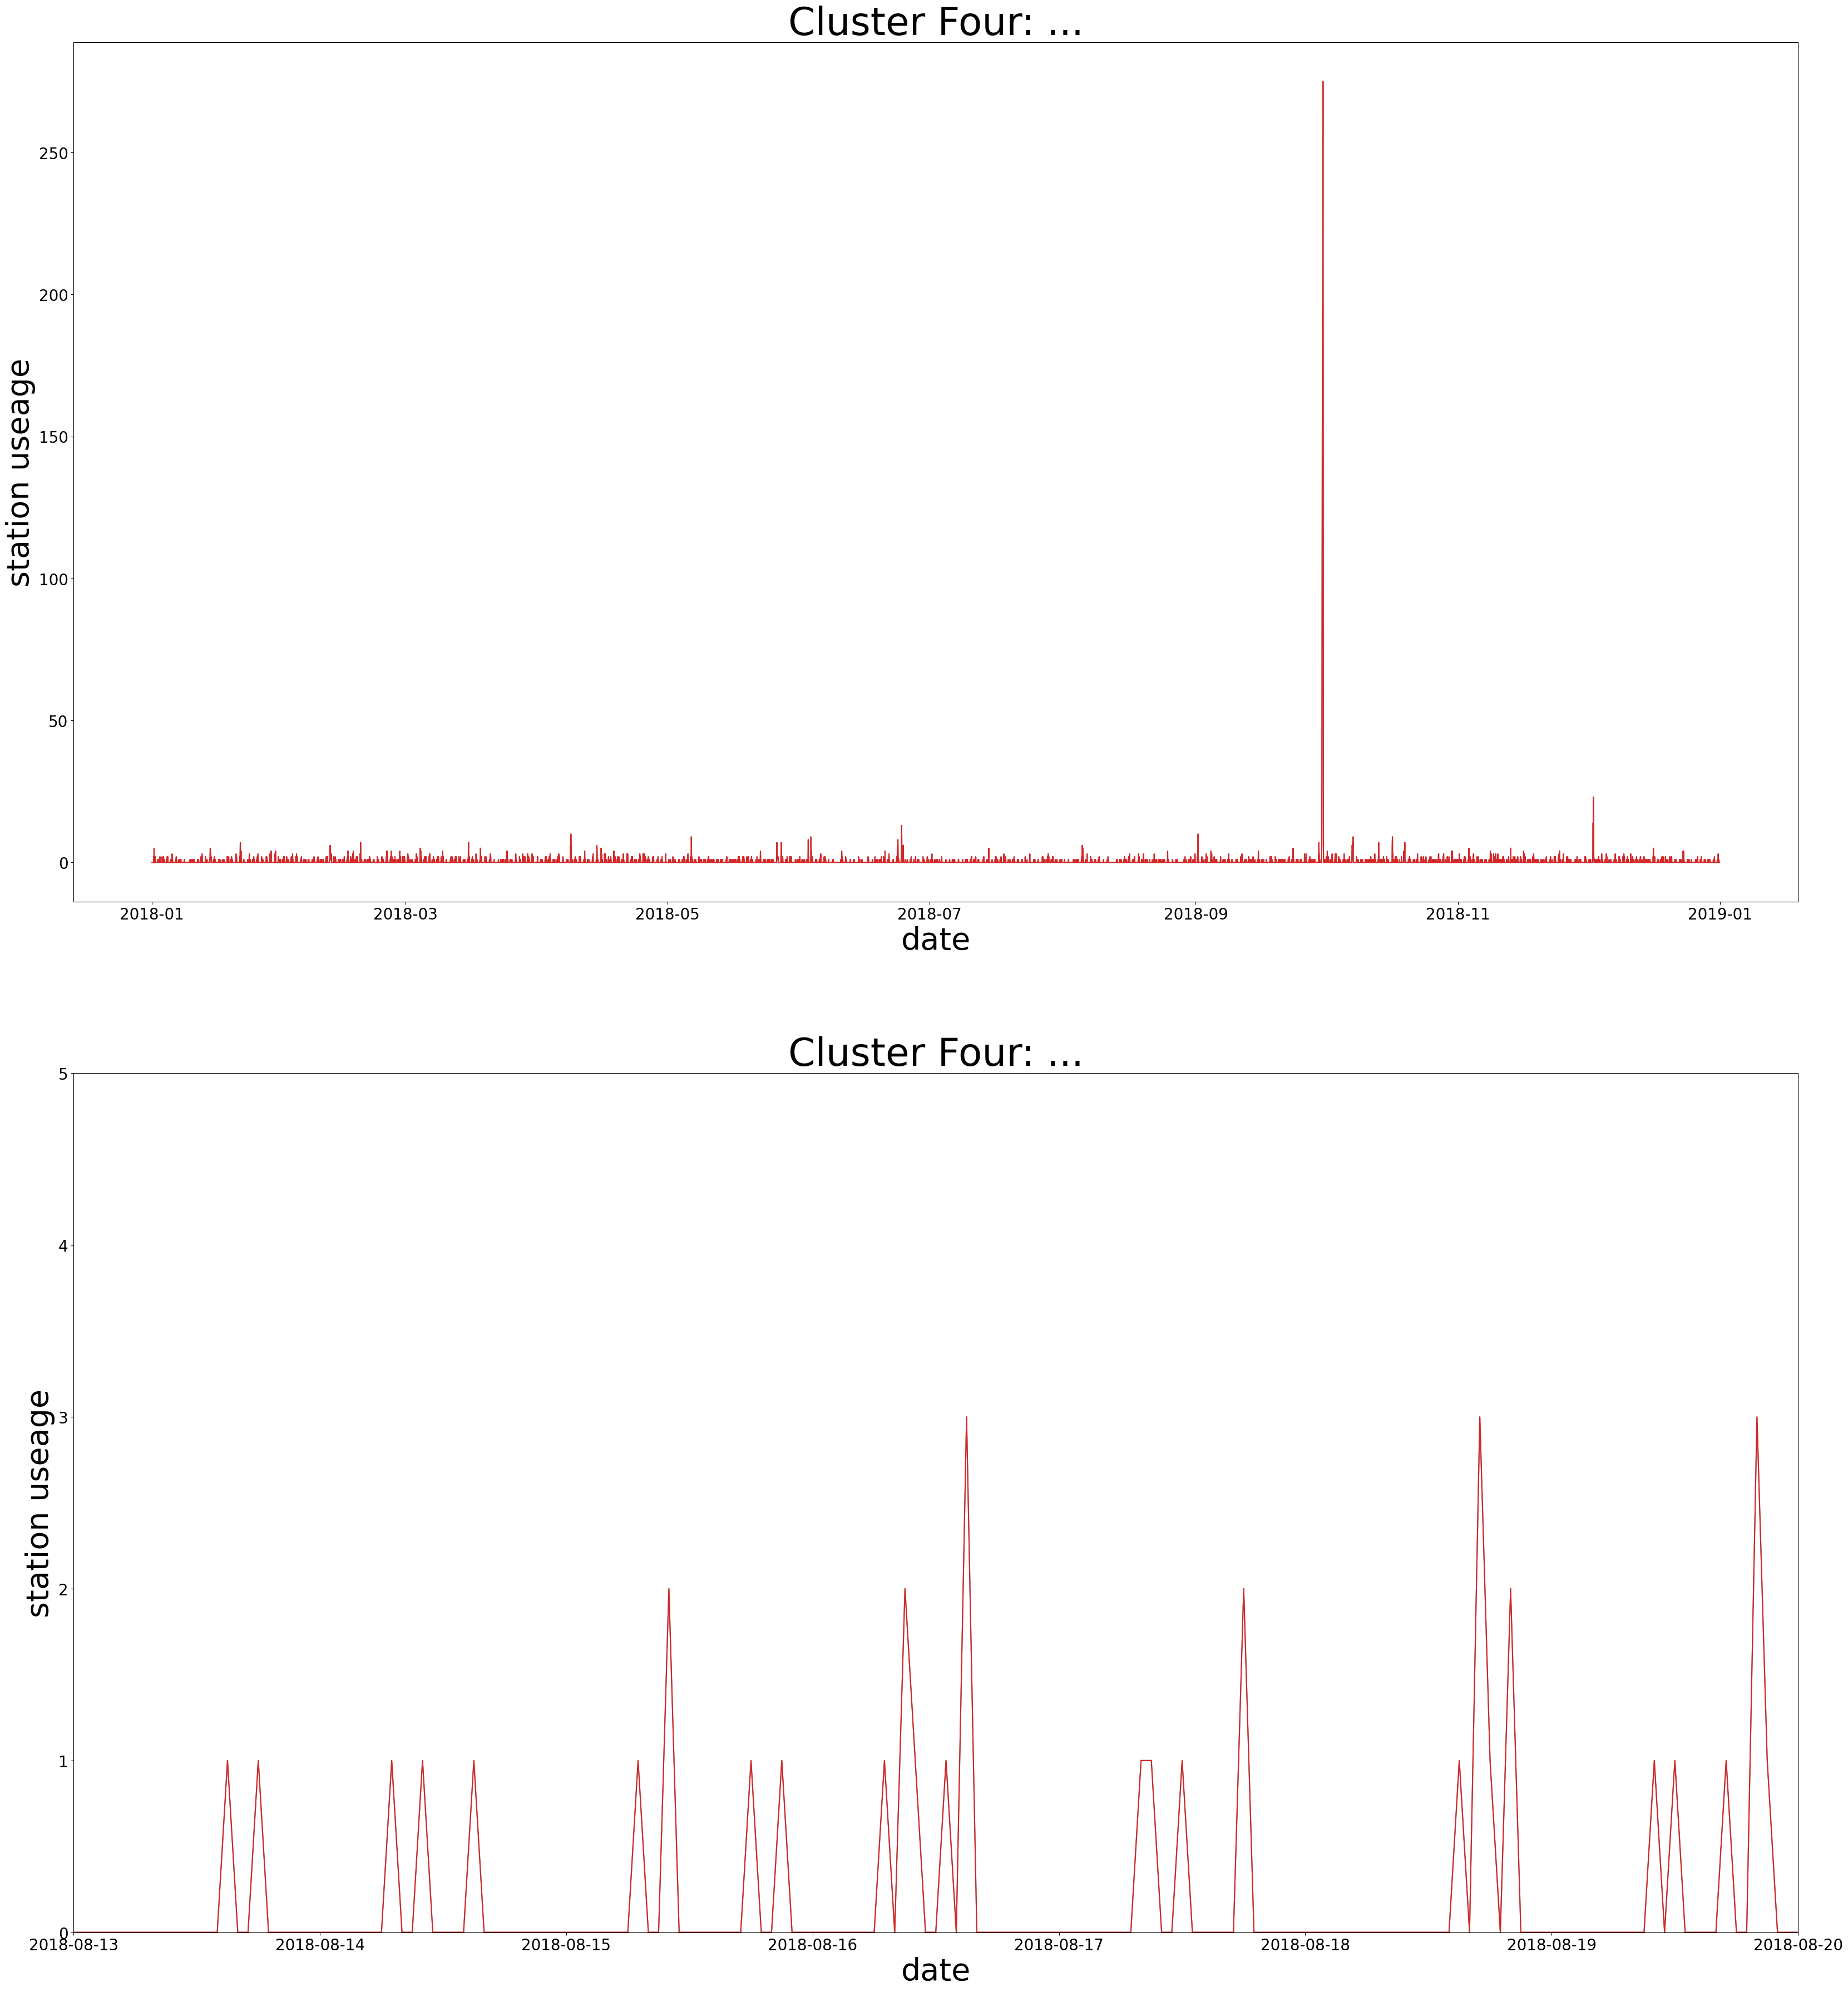

In [35]:
fig,ax = plt.subplots(2,1,figsize=(40,45), dpi=100) 
axis_font = {'size':'40'}
label_font = {'labelsize':'20'}
dic={'fontsize': '50'}

for i in [0,1]:
    for ts in cluster_4:
        #plot all timeseries of the respective cluster in gray
        ax[i].plot(station_cluster.transpose()[ts], color = 'tab:gray')
    
    #plot the mean value for all timeseries of the respective cluster in red
    ax[i].plot(station_cluster[station_cluster.index.isin(cluster_4)].mean(), color = 'tab:red')

    ax[i].set_title("Cluster Four: ...", dic)
    ax[i].set_ylabel('station useage',**axis_font)
    ax[i].set_xlabel('date',**axis_font)
    ax[i].tick_params(axis='both', **label_font)

ax[1].set_xlim([datetime.date(2018, 8, 13), datetime.date(2018, 8, 20)])
ax[1].set_ylim([0,5])
    
plt.show()

**todo: describe cluster**

<AxesSubplot:xlabel='lat', ylabel='lon'>

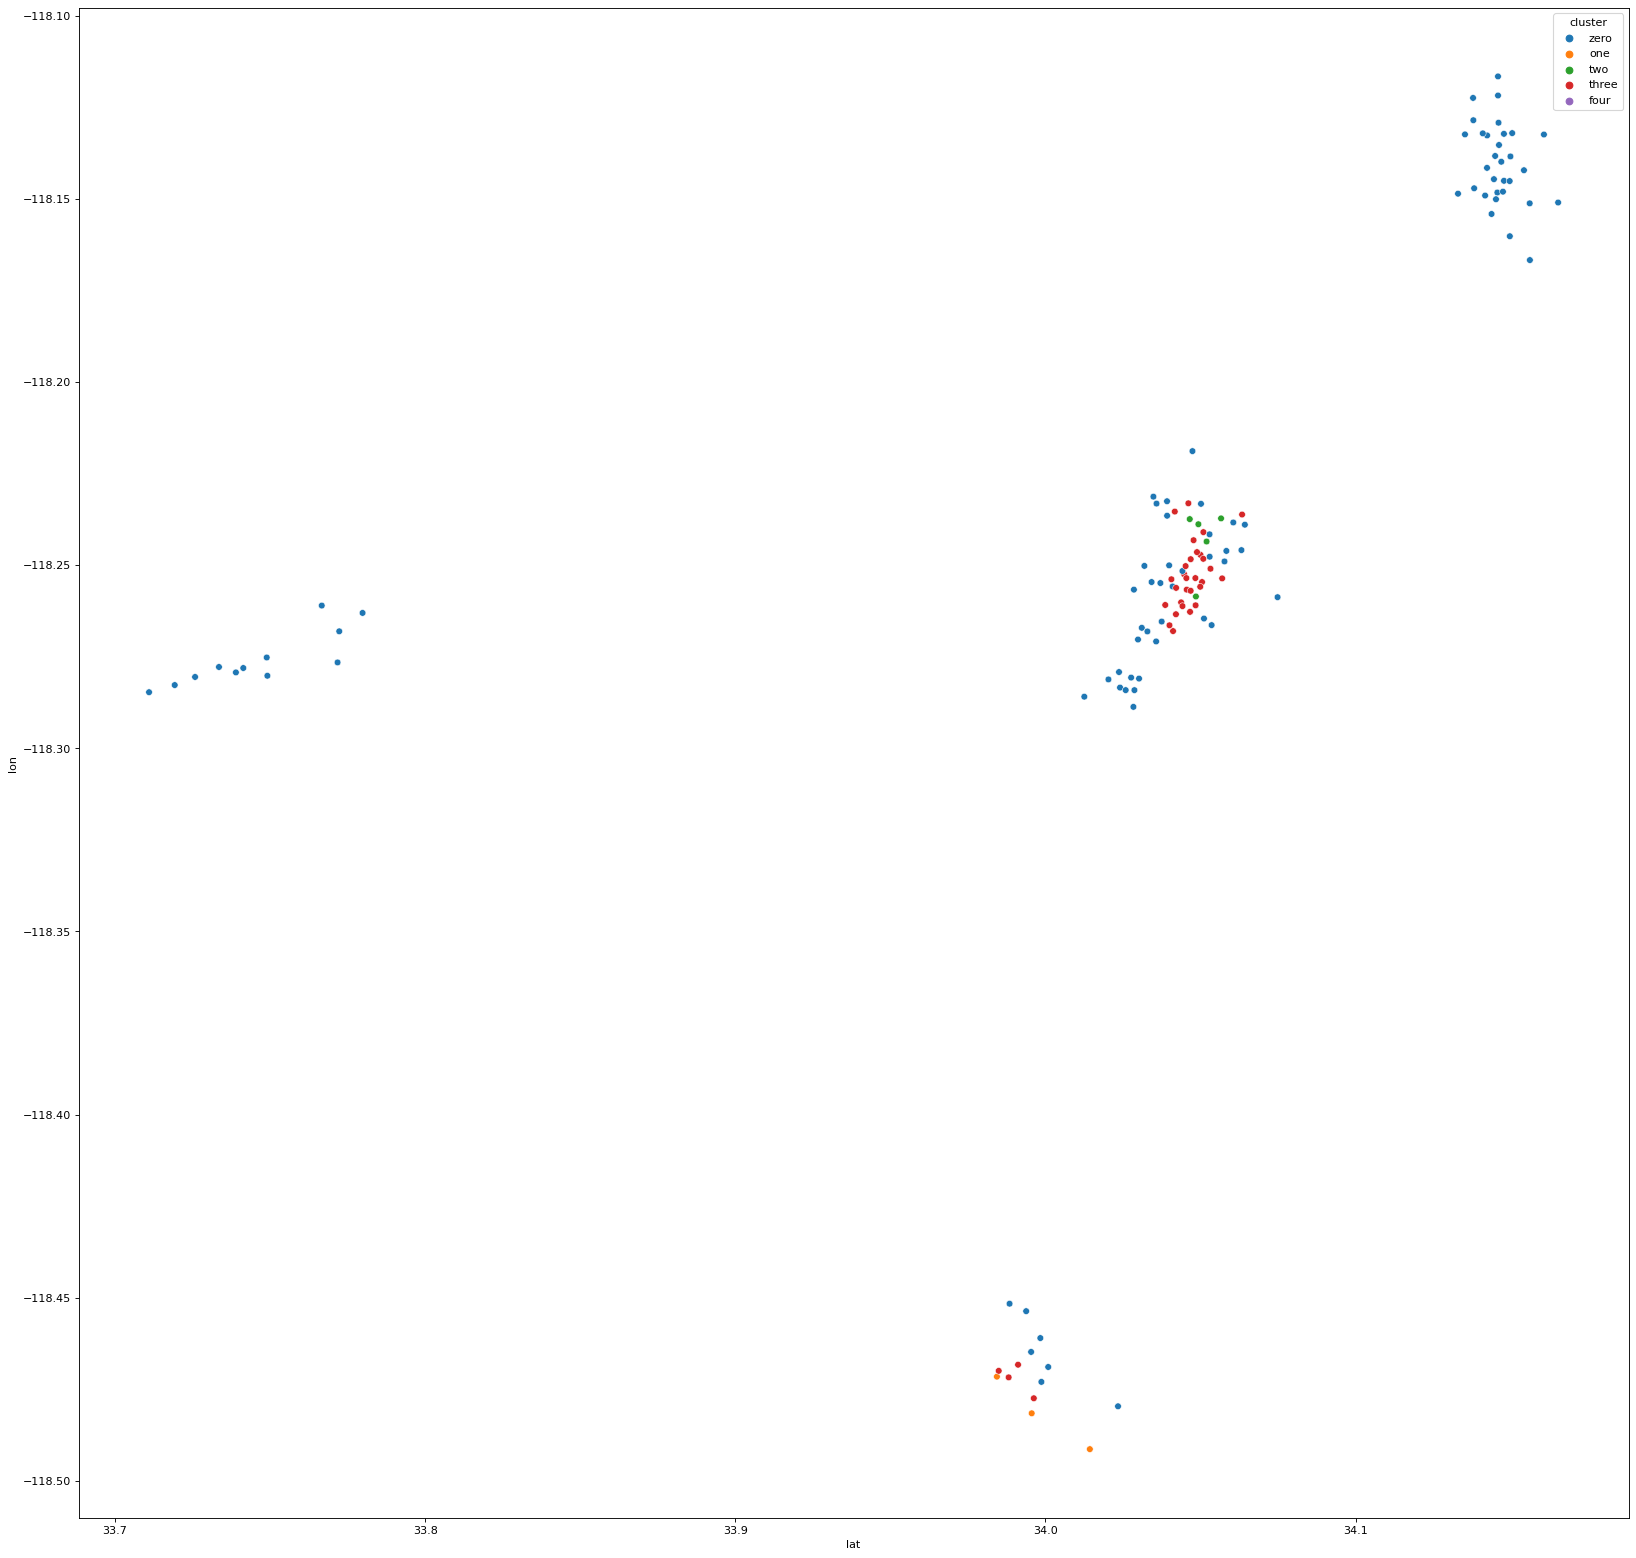

In [36]:
fig,ax = plt.subplots(figsize=(25,25), dpi= 80) 
axis_font = {'size':'20'}
label_font = {'labelsize':'12'}
dic={'fontsize': '24'}
sns.scatterplot(data=df_station2, x="lat", y="lon", hue="cluster",hue_order=numbers)